In [3]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)

In [4]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [6]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Cyclic Stocks

### Singapore Airlines

In [5]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14      OBV_7  labels
0  2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
1  2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2  2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
3  2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
4  2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


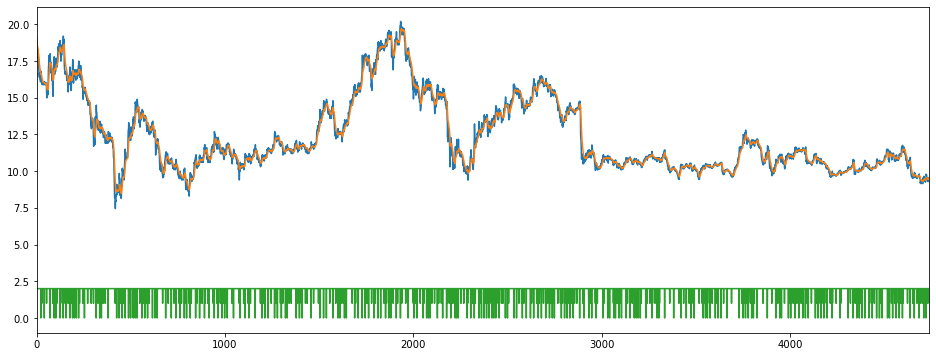

In [6]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [7]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0

In [8]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_10_price = []
data_10_willr = []
data_10_ema = []
data_10_obv = []
count = 0

for i in df.values:
    if count == 9:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_price_arr = min_max_scaler.fit_transform(data_10_price)
        data_10_ema_arr = min_max_scaler.fit_transform(data_10_ema)
        data_10_willr_arr = min_max_scaler.fit_transform(data_10_willr)
        data_10_obv_arr = min_max_scaler.fit_transform(data_10_obv)
        price_data.append(data_10_price_arr)
        willr_data.append(data_10_willr_arr)
        ema_data.append(data_10_ema_arr)
        obv_data.append(data_10_obv_arr)
        labels.append(i[-1])
        data_10_price = data_10_price[1:]
        data_10_willr = data_10_willr[1:]
        data_10_obv = data_10_obv[1:]
        data_10_ema = data_10_ema[1:]
    
    else:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        count += 1

In [9]:
willr_data = np.array(willr_data)
willr_data.shape

(4730, 10, 1)

In [10]:
price_data = np.array(price_data)
price_data.shape

(4730, 10, 1)

In [11]:
ema_data = np.array(ema_data)
ema_data.shape

(4730, 10, 1)

In [12]:
obv_data = np.array(obv_data)
obv_data.shape

(4730, 10, 1)

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [14]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4730, 64, 64, 1)

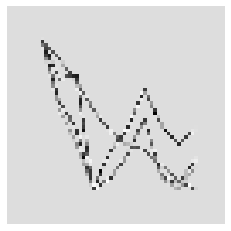

In [15]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [16]:
X = X/255

In [17]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [18]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [19]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [87]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [88]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.333333333333333, 1: 7.419607843137255, 2: 0.3664536122409452}
Epoch 1/200
30/30 [==============================] - 3s 105ms/step - loss: 0.2433 - accuracy: 0.3710 - mse: 1.5711 - weighted_accuracy: 0.3122 - weighted_mse: 1.6446 - val_loss: 0.2032 - val_accuracy: 0.0455 - val_mse: 1.0362 - val_weighted_accuracy: 0.0455 - val_weighted_mse: 1.0362
Epoch 2/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2032 - accuracy: 0.3652 - mse: 1.1648 - weighted_accuracy: 0.3489 - weighted_mse: 1.1693 - val_loss: 0.2003 - val_accuracy: 0.0455 - val_mse: 0.9810 - val_weighted_accuracy: 0.0455 - val_weighted_mse: 0.9810
Epoch 3/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2096 - accuracy: 0.3441 - mse: 1.1778 - weighted_accuracy: 0.3150 - weighted_mse: 1.2025 - val_loss: 0.1936 - val_accuracy: 0.8964 - val_mse: 0.8317 - val_weighted_accuracy: 0.8964 - val_weighted_mse: 0.8317
Epoch 4/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2059 

Epoch 57/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1771 - accuracy: 0.2349 - mse: 1.3009 - weighted_accuracy: 0.5047 - weighted_mse: 1.2728 - val_loss: 0.1920 - val_accuracy: 0.1406 - val_mse: 1.0910 - val_weighted_accuracy: 0.1406 - val_weighted_mse: 1.0910
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1781 - accuracy: 0.2135 - mse: 1.2628 - weighted_accuracy: 0.4951 - weighted_mse: 1.2479 - val_loss: 0.1915 - val_accuracy: 0.2178 - val_mse: 1.0562 - val_weighted_accuracy: 0.2178 - val_weighted_mse: 1.0562
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1758 - accuracy: 0.2159 - mse: 1.2954 - weighted_accuracy: 0.5145 - weighted_mse: 1.2683 - val_loss: 0.1965 - val_accuracy: 0.1184 - val_mse: 1.0414 - val_weighted_accuracy: 0.1184 - val_weighted_mse: 1.0414
Epoch 60/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1764 - accuracy: 0.2072 - mse: 1.2976 - weighted_accuracy: 0.5018 - weig

Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1553 - accuracy: 0.2392 - mse: 1.4637 - weighted_accuracy: 0.6120 - weighted_mse: 1.4437 - val_loss: 0.1680 - val_accuracy: 0.4852 - val_mse: 1.1420 - val_weighted_accuracy: 0.4852 - val_weighted_mse: 1.1420
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1543 - accuracy: 0.2801 - mse: 1.5412 - weighted_accuracy: 0.6233 - weighted_mse: 1.5312 - val_loss: 0.1885 - val_accuracy: 0.2717 - val_mse: 1.2884 - val_weighted_accuracy: 0.2717 - val_weighted_mse: 1.2884
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1538 - accuracy: 0.2310 - mse: 1.4562 - weighted_accuracy: 0.5980 - weighted_mse: 1.4426 - val_loss: 0.1986 - val_accuracy: 0.1882 - val_mse: 1.4117 - val_weighted_accuracy: 0.1882 - val_weighted_mse: 1.4117
Epoch 89/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1533 - accuracy: 0.2170 - mse: 1.5431 - weighted_accuracy: 0.6169 - weig

Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1377 - accuracy: 0.3528 - mse: 1.7095 - weighted_accuracy: 0.6835 - weighted_mse: 1.7570 - val_loss: 0.1823 - val_accuracy: 0.3721 - val_mse: 1.5234 - val_weighted_accuracy: 0.3721 - val_weighted_mse: 1.5234
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1346 - accuracy: 0.3554 - mse: 1.7607 - weighted_accuracy: 0.6917 - weighted_mse: 1.8391 - val_loss: 0.1816 - val_accuracy: 0.3943 - val_mse: 1.5695 - val_weighted_accuracy: 0.3943 - val_weighted_mse: 1.5695
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1359 - accuracy: 0.3570 - mse: 1.7611 - weighted_accuracy: 0.6776 - weighted_mse: 1.8538 - val_loss: 0.1746 - val_accuracy: 0.4376 - val_mse: 1.5039 - val_weighted_accuracy: 0.4376 - val_weighted_mse: 1.5039
Epoch 118/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1331 - accuracy: 0.3734 - mse: 1.7586 - weighted_accuracy: 0.7020 - 

Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1175 - accuracy: 0.5042 - mse: 2.0926 - weighted_accuracy: 0.7297 - weighted_mse: 2.4160 - val_loss: 0.1671 - val_accuracy: 0.5116 - val_mse: 1.8043 - val_weighted_accuracy: 0.5116 - val_weighted_mse: 1.8043
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1152 - accuracy: 0.5098 - mse: 2.1355 - weighted_accuracy: 0.7520 - weighted_mse: 2.4373 - val_loss: 0.1600 - val_accuracy: 0.5592 - val_mse: 1.7556 - val_weighted_accuracy: 0.5592 - val_weighted_mse: 1.7556
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1175 - accuracy: 0.5293 - mse: 2.1157 - weighted_accuracy: 0.7353 - weighted_mse: 2.4891 - val_loss: 0.1658 - val_accuracy: 0.5275 - val_mse: 1.8703 - val_weighted_accuracy: 0.5275 - val_weighted_mse: 1.8703
Epoch 147/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1177 - accuracy: 0.5169 - mse: 2.1610 - weighted_accuracy: 0.7288 - 

Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1016 - accuracy: 0.6142 - mse: 2.4597 - weighted_accuracy: 0.7829 - weighted_mse: 3.0438 - val_loss: 0.1493 - val_accuracy: 0.6395 - val_mse: 2.0830 - val_weighted_accuracy: 0.6395 - val_weighted_mse: 2.0830
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0992 - accuracy: 0.6274 - mse: 2.5807 - weighted_accuracy: 0.7786 - weighted_mse: 3.2606 - val_loss: 0.1394 - val_accuracy: 0.6818 - val_mse: 2.0068 - val_weighted_accuracy: 0.6818 - val_weighted_mse: 2.0068
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1001 - accuracy: 0.6234 - mse: 2.5633 - weighted_accuracy: 0.7919 - weighted_mse: 3.2417 - val_loss: 0.1473 - val_accuracy: 0.6427 - val_mse: 2.0634 - val_weighted_accuracy: 0.6427 - val_weighted_mse: 2.0634
Epoch 176/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1018 - accuracy: 0.6290 - mse: 2.5438 - weighted_accuracy: 0.7847 - 

In [89]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.13233639299869537
Test accuracy: 0.7219873070716858


In [90]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.7900518  -1.1490977  -0.11176229]
 [-0.5163281  -2.505155   -0.24435663]
 [-0.19656542 -2.5933914  -0.5170185 ]
 ...
 [-1.1210771  -1.8185564   0.10523999]
 [-0.8326715  -1.565515   -0.07830465]
 [-0.45595402 -2.26685    -0.3082517 ]]


Counter({2: 739, 0: 90, 1: 117})

In [91]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 860, 0: 43, 1: 43})

In [92]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 946
actual predicted buys: 10
actual buys but predicted sell: 1
actual buys but predicted hold: 32
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 38
actual holds but predicted buy: 106
actual holds but predicted sell: 85
actual predicted holds: 669
Percentage buys correct: 23.25581395348837%
Percentage sells correct: 9.30232558139535%
Percentage holds correct: 77.79069767441861%
actual buys: 43
actual sells: 43
actual holds: 860


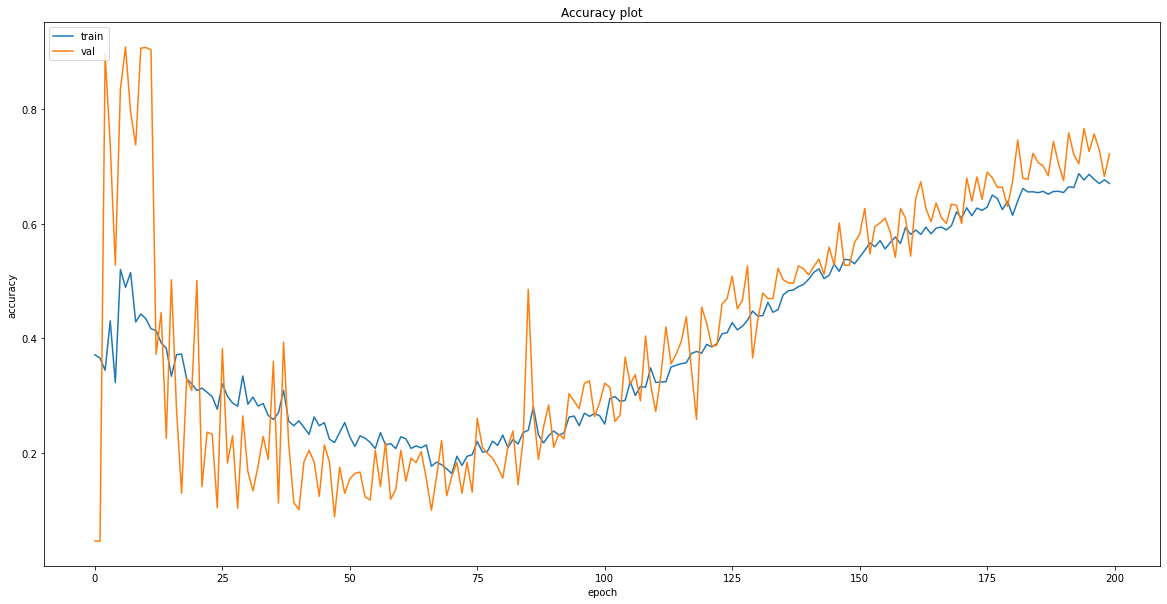

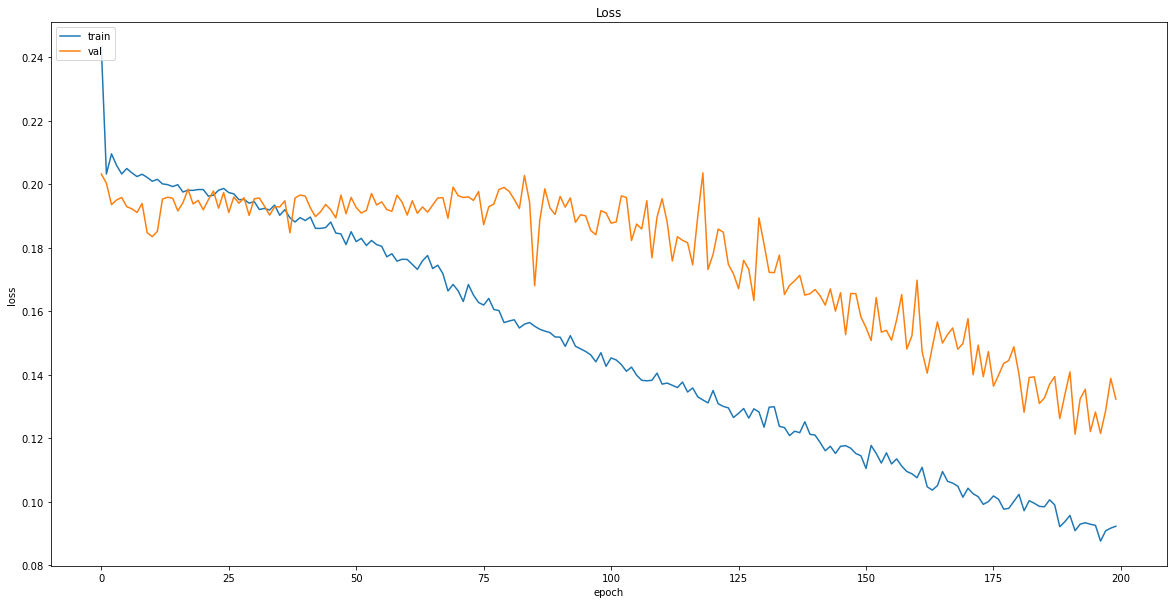

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [94]:
# Save model
model.save("models/{}".format('Singapore_Airlines_image_cnn_buy_hold_sell_10.model'))

INFO:tensorflow:Assets written to: models/Singapore_Airlines_image_cnn_buy_hold_sell_10.model\assets


### Test Performance

### non-recession

In [95]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-01-28         9.72  9.602493 -20.000000  7026900.0     0.0
2019-01-29         9.75  9.625186 -15.000083  7689700.0     2.0
2019-01-30         9.64  9.627465 -51.515038  6232300.0     2.0
2019-01-31         9.66  9.632471 -45.454598  7395400.0     2.0
2019-02-01         9.65  9.635167 -48.484962  5664000.0     2.0


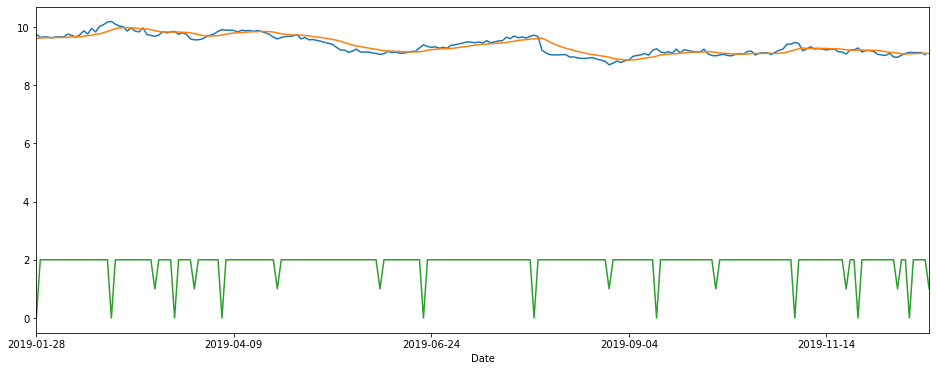

In [96]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [97]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_10_price = []
data_10_willr = []
data_10_ema = []
data_10_obv = []
count = 0

for i in df.values:
    if count == 9:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_price_arr = min_max_scaler.fit_transform(data_10_price)
        data_10_ema_arr = min_max_scaler.fit_transform(data_10_ema)
        data_10_willr_arr = min_max_scaler.fit_transform(data_10_willr)
        data_10_obv_arr = min_max_scaler.fit_transform(data_10_obv)
        price_data.append(data_10_price_arr)
        willr_data.append(data_10_willr_arr)
        ema_data.append(data_10_ema_arr)
        obv_data.append(data_10_obv_arr)
        labels.append(i[-1])
        data_10_price = data_10_price[1:]
        data_10_willr = data_10_willr[1:]
        data_10_obv = data_10_obv[1:]
        data_10_ema = data_10_ema[1:]
    
    else:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        count += 1

In [98]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [99]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [100]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [101]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [102]:
model = tf.keras.models.load_model("models/Singapore_Airlines_image_cnn_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1372 - accuracy: 0.7064 - mean_squared_error: 2.2161 - weighted_accuracy: 0.7064 - weighted_mean_squared_error: 2.2161
Test loss: 0.1372174322605133
Test accuracy: 0.7064220309257507


In [103]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 160, 0: 22, 1: 36})

In [104]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 200, 0: 9, 1: 9})

In [105]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels  predictions  \
Date                                                                           
2019-02-11         9.71  9.662247 -15.151533  6464788.0     2.0            2   
2019-02-12         9.65  9.669594 -30.303065  5675088.0     2.0            2   
2019-02-13         9.73  9.666579 -48.484962  4337188.0     2.0            2   
2019-02-14         9.87  9.676336 -32.000351  5826588.0     2.0            2   
2019-02-15         9.76  9.706131  -6.250130  8384988.0     2.0            2   

            actual  
Date                
2019-02-11       2  
2019-02-12       2  
2019-02-13       2  
2019-02-14       2  
2019-02-15       2

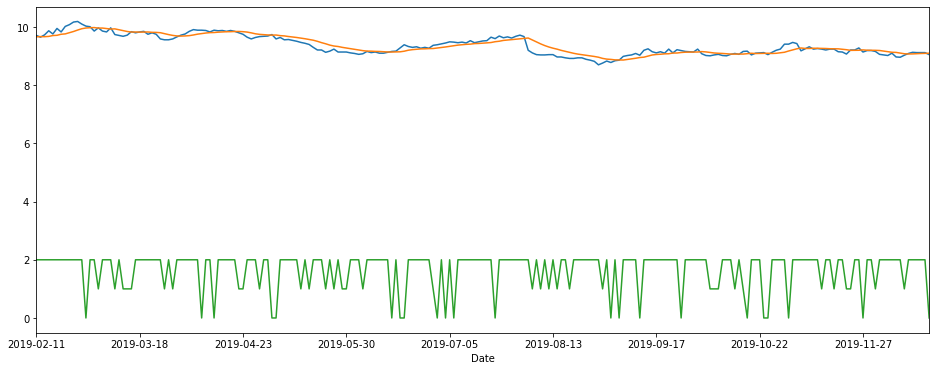

In [106]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

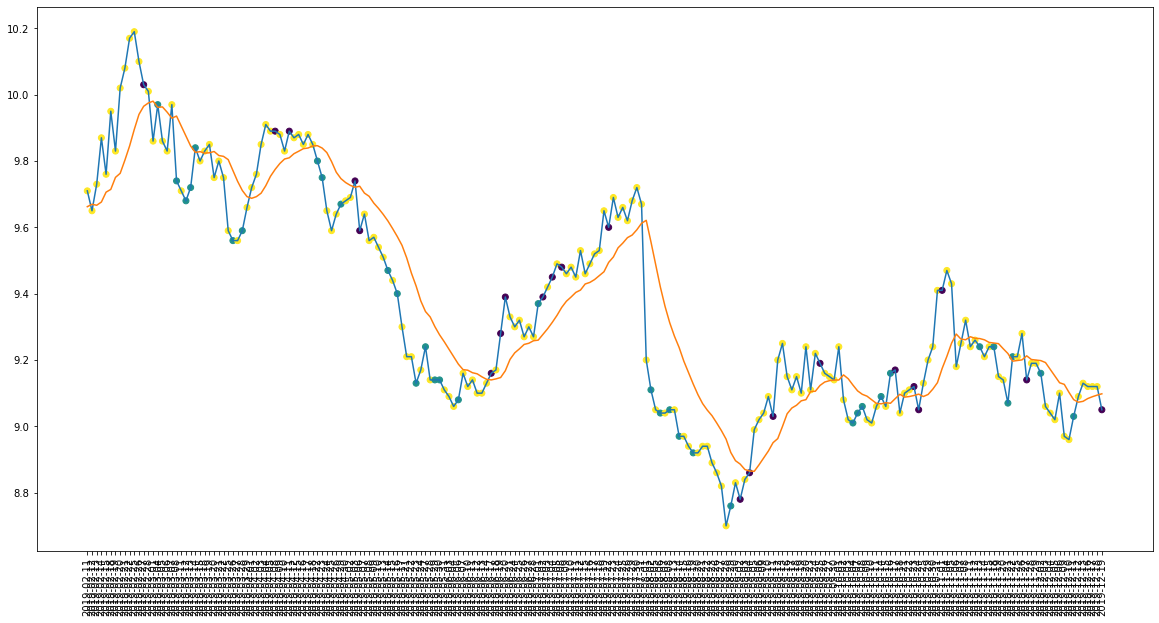

In [107]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

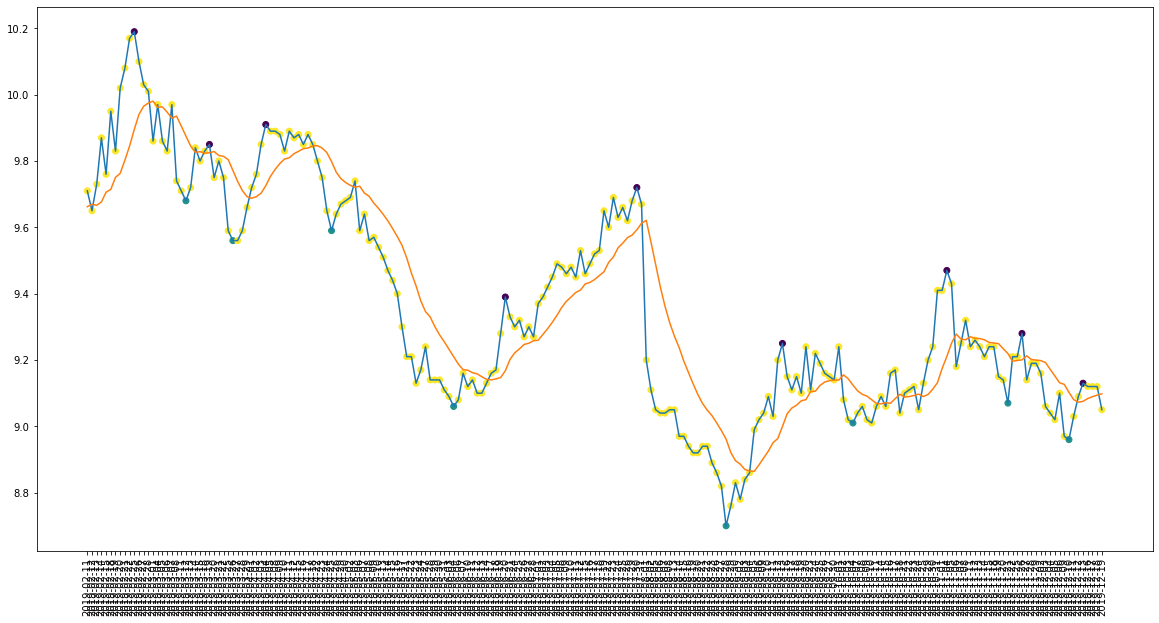

In [108]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [109]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 31
actual holds but predicted sell: 21
actual predicted holds: 148
Percentage buys correct: 55.55555555555556%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 74.0%
actual buys: 9
actual sells: 9
actual holds: 200


In [110]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[9.649999618530273, 9.710000038146973, 9.729999542236328, 9.760000228881836, 9.829999923706056, 9.869999885559082, 9.949999809265137, 10.020000457763672, 10.079999923706056]
[9.829999923706056, 9.859999656677246, 10.010000228881836, 10.020000457763672, 10.029999732971193, 10.079999923706056, 10.100000381469727, 10.170000076293944, 10.1899995803833]
Percentage buys correct: 42.857142857142854%
Percentage sells correct: 36.36363636363637%
Percentage holds correct: 79.375%


In [111]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $9.970000267028807
Shares owned at the moment: 1000
Cash capital at the moment: $2.5822322368640016


Stop Loss Activated!

Share price: $9.68000030517578
Shares owned at the moment: 0
Cash capital at the moment: $9655.96253657341


Share price: $9.68000030517578
Shares owned at the moment: 994
Cash capital at the moment: $7.581952394486507


Stop Loss Activated!

Share price: $9.399999618530273
Shares owned at the moment: 0
Cash capital at the moment: $9325.486674256326


Share price: $9.399999618530273
Shares owned at the moment: 989
Cash capital at the moment: $3.3214025673878496


Stop Loss Activated!

Share price: $9.130000114440918
Shares owned at the moment: 0
Cash capital at the moment: $9008.060197938205


Share price: $9.130000114440918
Shares owned at the moment: 983
Cash capital at the moment: $8.58941263341876


Stop Loss Activated!

Share price: $8.859999656677246
Shares owned at the moment: 0
Cash capital at the moment: $8694.01828107524


Share price: $8.76

In [112]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9269.197226061342
profit gained: -7.30802773938658%


### Recession

In [113]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test2.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-30         8.57  8.828210 -85.245891 -3263600.0     2.0
2020-01-31         8.54  8.783870 -90.163875 -5360700.0     2.0
2020-02-03         8.55  8.747890 -88.524495 -2703900.0     1.0
2020-02-04         8.49  8.708214 -96.774273 -5257100.0     2.0
2020-02-05         8.55  8.683874 -87.096784 -3170600.0     2.0


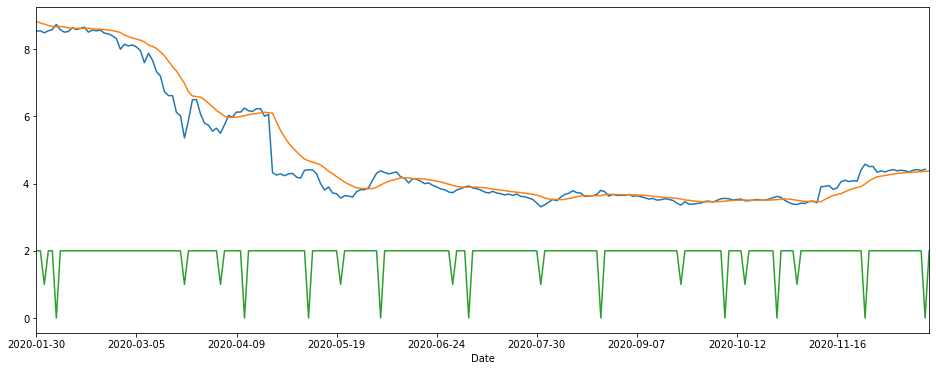

In [114]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [115]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_10_price = []
data_10_willr = []
data_10_ema = []
data_10_obv = []
count = 0

for i in df.values:
    if count == 9:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_price_arr = min_max_scaler.fit_transform(data_10_price)
        data_10_ema_arr = min_max_scaler.fit_transform(data_10_ema)
        data_10_willr_arr = min_max_scaler.fit_transform(data_10_willr)
        data_10_obv_arr = min_max_scaler.fit_transform(data_10_obv)
        price_data.append(data_10_price_arr)
        willr_data.append(data_10_willr_arr)
        ema_data.append(data_10_ema_arr)
        obv_data.append(data_10_obv_arr)
        labels.append(i[-1])
        data_10_price = data_10_price[1:]
        data_10_willr = data_10_willr[1:]
        data_10_obv = data_10_obv[1:]
        data_10_ema = data_10_ema[1:]
    
    else:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        count += 1

In [116]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [117]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [118]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [119]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [120]:
model = tf.keras.models.load_model("models/Singapore_Airlines_image_cnn_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 6ms/step - loss: 0.1382 - accuracy: 0.7023 - mean_squared_error: 2.1695 - weighted_accuracy: 0.7023 - weighted_mean_squared_error: 2.1695
Test loss: 0.13824419677257538
Test accuracy: 0.7023255825042725


In [121]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 158, 1: 36, 0: 21})

In [122]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [123]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels  predictions  \
Date                                                                           
2020-02-12         8.64  8.623953 -86.440694 -2356000.0     2.0            2   
2020-02-13         8.59  8.626421 -61.224363  -575600.0     2.0            2   
2020-02-14         8.62  8.620818 -64.102508 -2132700.0     2.0            2   
2020-02-17         8.66  8.620692 -45.161340  -798700.0     2.0            2   
2020-02-18         8.51  8.626740 -32.258144   341600.0     2.0            2   

            actual  
Date                
2020-02-12       2  
2020-02-13       2  
2020-02-14       2  
2020-02-17       2  
2020-02-18       2

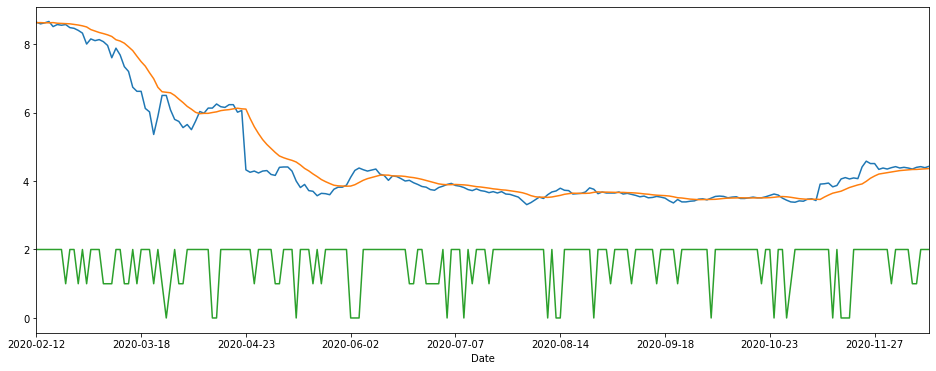

In [124]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

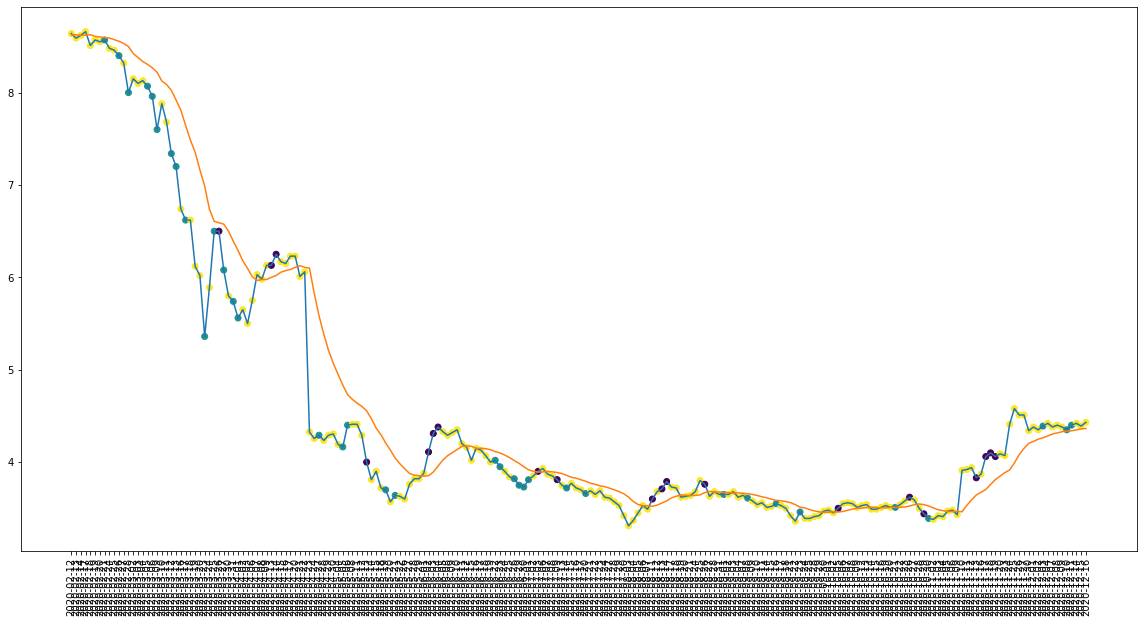

In [125]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

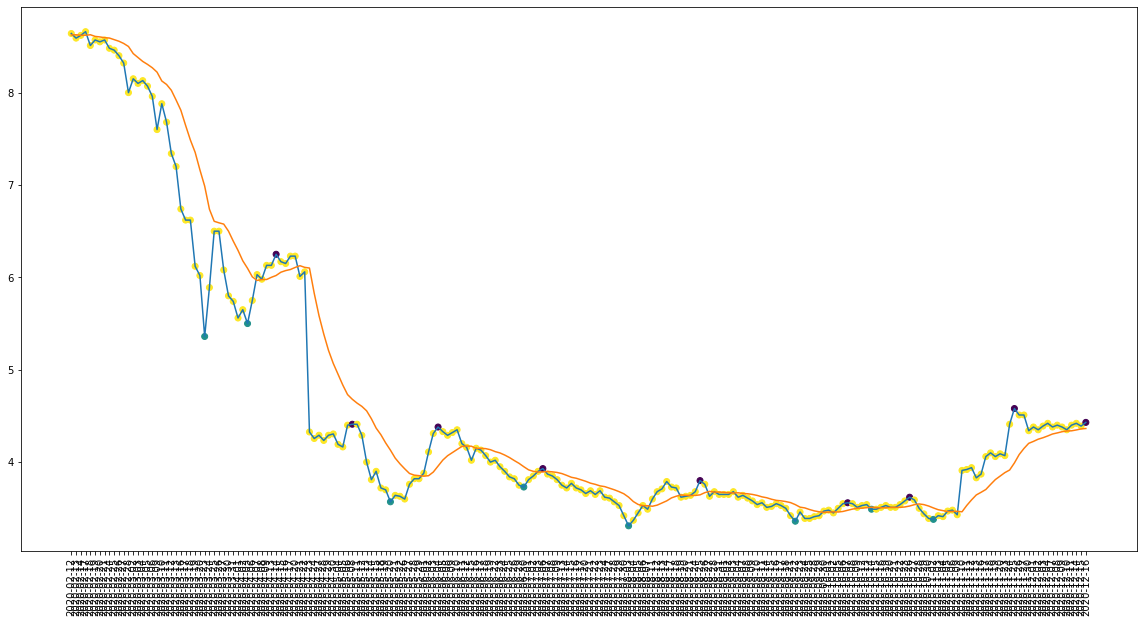

In [126]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [127]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 215
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 34
actual holds but predicted sell: 18
actual predicted holds: 146
Percentage buys correct: 25.0%
Percentage sells correct: 33.333333333333336%
Percentage holds correct: 73.73737373737374%
actual buys: 8
actual sells: 9
actual holds: 198


In [128]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[8.479999542236326, 8.510000228881836, 8.550000190734862, 8.569999694824219, 8.569999694824219, 8.590000152587889, 8.619999885559082, 8.640000343322754, 8.659999847412111]
[8.0, 8.100000381469728, 8.149999618530272, 8.319999694824219, 8.399999618530272, 8.460000038146973, 8.479999542236326, 8.550000190734862, 8.569999694824219]
Percentage buys correct: 52.77777777777778%
Percentage sells correct: 55.0%
Percentage holds correct: 87.34177215189874%


In [129]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $8.569999694824219
Shares owned at the moment: 1163
Cash capital at the moment: $5.681353395460974


Stop Loss Activated!

Share price: $8.319999694824219
Shares owned at the moment: 0
Cash capital at the moment: $9655.231559452055


Share price: $8.0
Shares owned at the moment: 1203
Cash capital at the moment: $4.765559452054731


Stop Loss Activated!

Share price: $7.599999904632567
Shares owned at the moment: 0
Cash capital at the moment: $9122.422745040532


Share price: $7.599999904632567
Shares owned at the moment: 1197
Cash capital at the moment: $0.20555950927519007


Stop Loss Activated!

Share price: $7.3400001525878915
Shares owned at the moment: 0
Cash capital at the moment: $8762.024296654701


Share price: $7.3400001525878915
Shares owned at the moment: 1190
Cash capital at the moment: $3.4039645757657127


Stop Loss Activated!

Share price: $6.739999771118164
Shares owned at the moment: 0
Cash capital at the moment: $8001.947042955397


Share price: $6.61999

In [130]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5100.181760163545
profit gained: -48.998182398364555%


### OCBC Bank

In [11]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14      OBV_7  labels
0  2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
1  2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2  2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
3  2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
4  2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


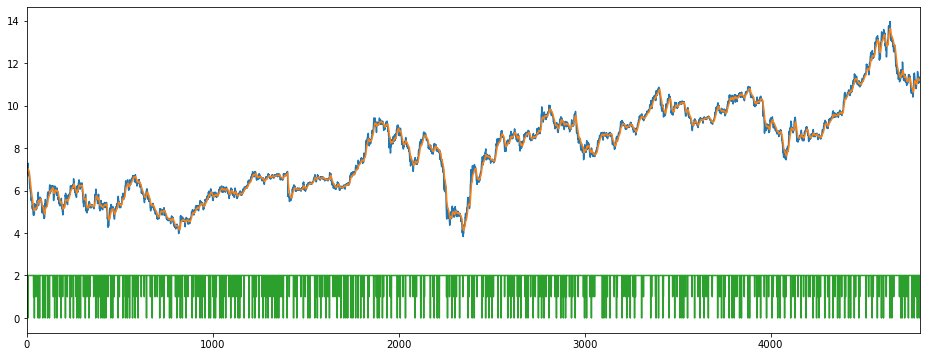

In [12]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [13]:
df.set_index('Date', inplace=True)
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0

In [14]:
# willr_data = []
# price_data = []
# ema_data = []
# obv_data = []
# labels = []
# data_15_price = []
# data_15_willr = []
# data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         ema_data.append(data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1

In [15]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_10_price = []
data_10_willr = []
data_10_ema = []
data_10_obv = []
count = 0

for i in df.values:
    if count == 9:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_price_arr = min_max_scaler.fit_transform(data_10_price)
        data_10_ema_arr = min_max_scaler.fit_transform(data_10_ema)
        data_10_willr_arr = min_max_scaler.fit_transform(data_10_willr)
        data_10_obv_arr = min_max_scaler.fit_transform(data_10_obv)
        price_data.append(data_10_price_arr)
        willr_data.append(data_10_willr_arr)
        ema_data.append(data_10_ema_arr)
        obv_data.append(data_10_obv_arr)
        labels.append(i[-1])
        data_10_price = data_10_price[1:]
        data_10_willr = data_10_willr[1:]
        data_10_obv = data_10_obv[1:]
        data_10_ema = data_10_ema[1:]
    
    else:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        count += 1

In [16]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [18]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4794, 64, 64, 1)

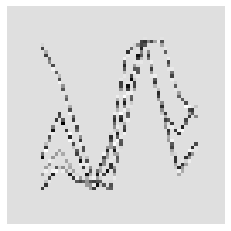

In [19]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [20]:
X = X/255

In [21]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [22]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [23]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [25]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.263257575757576, 1: 7.9399585921325055, 2: 0.3654469220506956}
Epoch 1/200
 1/30 [>.............................] - ETA: 0s - loss: 0.5327 - accuracy: 0.7031 - mse: 5.6294 - weighted_accuracy: 0.4353 - weighted_mse: 6.5091WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
30/30 [==============================] - 1s 24ms/step - loss: 0.2521 - accuracy: 0.3458 - mse: 1.6722 - weighted_accuracy: 0.3156 - weighted_mse: 1.7672 - val_loss: 0.1913 - val_accuracy: 0.6882 - val_mse: 0.8215 - val_weighted_accuracy: 0.6882 - val_weighted_mse: 0.8215
Epoch 2/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2067 - accuracy: 0.4522 - mse: 1.1157 - weighted_accuracy: 0.3406 - weighted_mse: 1.1637 - val_loss: 0.1833 - val_accuracy: 0.7435 - va

Epoch 27/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1836 - accuracy: 0.2858 - mse: 1.3162 - weighted_accuracy: 0.5087 - weighted_mse: 1.2818 - val_loss: 0.1891 - val_accuracy: 0.2795 - val_mse: 1.0611 - val_weighted_accuracy: 0.2795 - val_weighted_mse: 1.0611
Epoch 28/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1838 - accuracy: 0.2999 - mse: 1.3181 - weighted_accuracy: 0.5054 - weighted_mse: 1.2757 - val_loss: 0.2001 - val_accuracy: 0.1627 - val_mse: 0.9861 - val_weighted_accuracy: 0.1627 - val_weighted_mse: 0.9861
Epoch 29/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1814 - accuracy: 0.2756 - mse: 1.3316 - weighted_accuracy: 0.5217 - weighted_mse: 1.2736 - val_loss: 0.1695 - val_accuracy: 0.5756 - val_mse: 1.1524 - val_weighted_accuracy: 0.5756 - val_weighted_mse: 1.1524
Epoch 30/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1809 - accuracy: 0.2824 - mse: 1.3579 - weighted_accuracy: 0.5077 - weig

Epoch 56/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1583 - accuracy: 0.3082 - mse: 1.5455 - weighted_accuracy: 0.6093 - weighted_mse: 1.5086 - val_loss: 0.1829 - val_accuracy: 0.3577 - val_mse: 1.2448 - val_weighted_accuracy: 0.3577 - val_weighted_mse: 1.2448
Epoch 57/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1599 - accuracy: 0.3176 - mse: 1.5313 - weighted_accuracy: 0.5930 - weighted_mse: 1.4743 - val_loss: 0.1970 - val_accuracy: 0.2669 - val_mse: 1.1730 - val_weighted_accuracy: 0.2669 - val_weighted_mse: 1.1730
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1548 - accuracy: 0.3012 - mse: 1.5642 - weighted_accuracy: 0.6269 - weighted_mse: 1.5403 - val_loss: 0.1867 - val_accuracy: 0.3316 - val_mse: 1.2577 - val_weighted_accuracy: 0.3316 - val_weighted_mse: 1.2577
Epoch 59/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1553 - accuracy: 0.3215 - mse: 1.5782 - weighted_accuracy: 0.6181 - wei

Epoch 85/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1391 - accuracy: 0.4086 - mse: 1.6939 - weighted_accuracy: 0.6879 - weighted_mse: 1.7541 - val_loss: 0.1836 - val_accuracy: 0.3556 - val_mse: 1.5183 - val_weighted_accuracy: 0.3556 - val_weighted_mse: 1.5183
Epoch 86/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1387 - accuracy: 0.3885 - mse: 1.8056 - weighted_accuracy: 0.6850 - weighted_mse: 1.8889 - val_loss: 0.1889 - val_accuracy: 0.3368 - val_mse: 1.4245 - val_weighted_accuracy: 0.3368 - val_weighted_mse: 1.4245
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1427 - accuracy: 0.4271 - mse: 1.8002 - weighted_accuracy: 0.6551 - weighted_mse: 1.8151 - val_loss: 0.1853 - val_accuracy: 0.3608 - val_mse: 1.4993 - val_weighted_accuracy: 0.3608 - val_weighted_mse: 1.4993
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1401 - accuracy: 0.3786 - mse: 1.8122 - weighted_accuracy: 0.6681 - wei

Epoch 114/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1220 - accuracy: 0.5129 - mse: 1.9689 - weighted_accuracy: 0.7297 - weighted_mse: 2.2417 - val_loss: 0.1581 - val_accuracy: 0.5693 - val_mse: 1.5759 - val_weighted_accuracy: 0.5693 - val_weighted_mse: 1.5759
Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1204 - accuracy: 0.5351 - mse: 2.0504 - weighted_accuracy: 0.7355 - weighted_mse: 2.3296 - val_loss: 0.1687 - val_accuracy: 0.5047 - val_mse: 1.7609 - val_weighted_accuracy: 0.5047 - val_weighted_mse: 1.7609
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1226 - accuracy: 0.5129 - mse: 2.0884 - weighted_accuracy: 0.7218 - weighted_mse: 2.4131 - val_loss: 0.1628 - val_accuracy: 0.5245 - val_mse: 1.6430 - val_weighted_accuracy: 0.5245 - val_weighted_mse: 1.6430
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1234 - accuracy: 0.5270 - mse: 1.9932 - weighted_accuracy: 0.7351 - 

Epoch 143/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1062 - accuracy: 0.6169 - mse: 2.3757 - weighted_accuracy: 0.7854 - weighted_mse: 2.7934 - val_loss: 0.1442 - val_accuracy: 0.6517 - val_mse: 1.8756 - val_weighted_accuracy: 0.6517 - val_weighted_mse: 1.8756
Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1031 - accuracy: 0.6326 - mse: 2.3828 - weighted_accuracy: 0.7868 - weighted_mse: 2.9596 - val_loss: 0.1486 - val_accuracy: 0.6225 - val_mse: 1.9315 - val_weighted_accuracy: 0.6225 - val_weighted_mse: 1.9315
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1070 - accuracy: 0.6248 - mse: 2.3850 - weighted_accuracy: 0.7600 - weighted_mse: 2.9467 - val_loss: 0.1463 - val_accuracy: 0.6288 - val_mse: 1.8683 - val_weighted_accuracy: 0.6288 - val_weighted_mse: 1.8683
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1080 - accuracy: 0.6258 - mse: 2.3536 - weighted_accuracy: 0.7714 - 

Epoch 172/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0912 - accuracy: 0.6850 - mse: 2.8791 - weighted_accuracy: 0.8169 - weighted_mse: 3.8411 - val_loss: 0.1267 - val_accuracy: 0.7268 - val_mse: 2.1676 - val_weighted_accuracy: 0.7268 - val_weighted_mse: 2.1676
Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0949 - accuracy: 0.6801 - mse: 2.7367 - weighted_accuracy: 0.8061 - weighted_mse: 3.5670 - val_loss: 0.1185 - val_accuracy: 0.7643 - val_mse: 2.0887 - val_weighted_accuracy: 0.7643 - val_weighted_mse: 2.0887
Epoch 174/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0900 - accuracy: 0.6918 - mse: 2.9538 - weighted_accuracy: 0.8169 - weighted_mse: 3.9857 - val_loss: 0.1249 - val_accuracy: 0.7404 - val_mse: 2.1469 - val_weighted_accuracy: 0.7404 - val_weighted_mse: 2.1469
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0918 - accuracy: 0.6944 - mse: 2.8871 - weighted_accuracy: 0.8184 -

In [26]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.11401373893022537
Test accuracy: 0.7799791693687439


In [27]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.432351   -2.9434988   0.7628405 ]
 [-1.0741976  -2.1793687   0.3931504 ]
 [-1.3902755  -1.8665134   0.43558764]
 ...
 [-2.734987   -0.3998205  -0.50597423]
 [-0.76140964 -2.04662    -0.02159899]
 [-0.06490457 -2.6685958  -0.6260474 ]]


Counter({2: 814, 0: 96, 1: 49})

In [28]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 875, 1: 40, 0: 44})

In [29]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 959
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 38
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 36
actual holds but predicted buy: 45
actual holds but predicted sell: 90
actual predicted holds: 740
Percentage buys correct: 5.0%
Percentage sells correct: 13.636363636363637%
Percentage holds correct: 84.57142857142857%
actual buys: 40
actual sells: 44
actual holds: 875


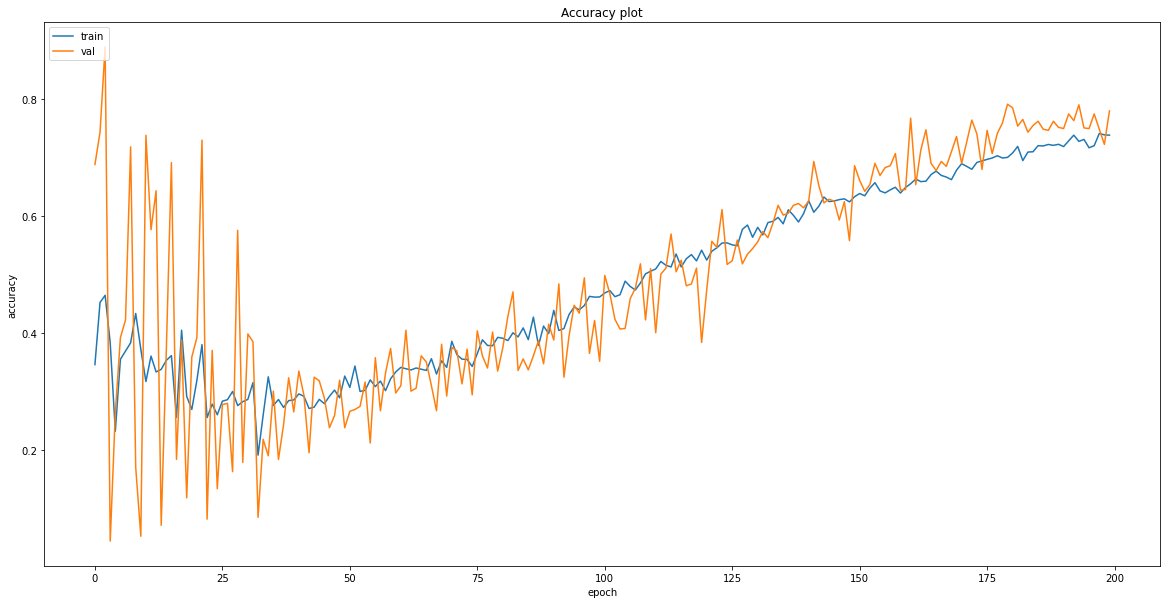

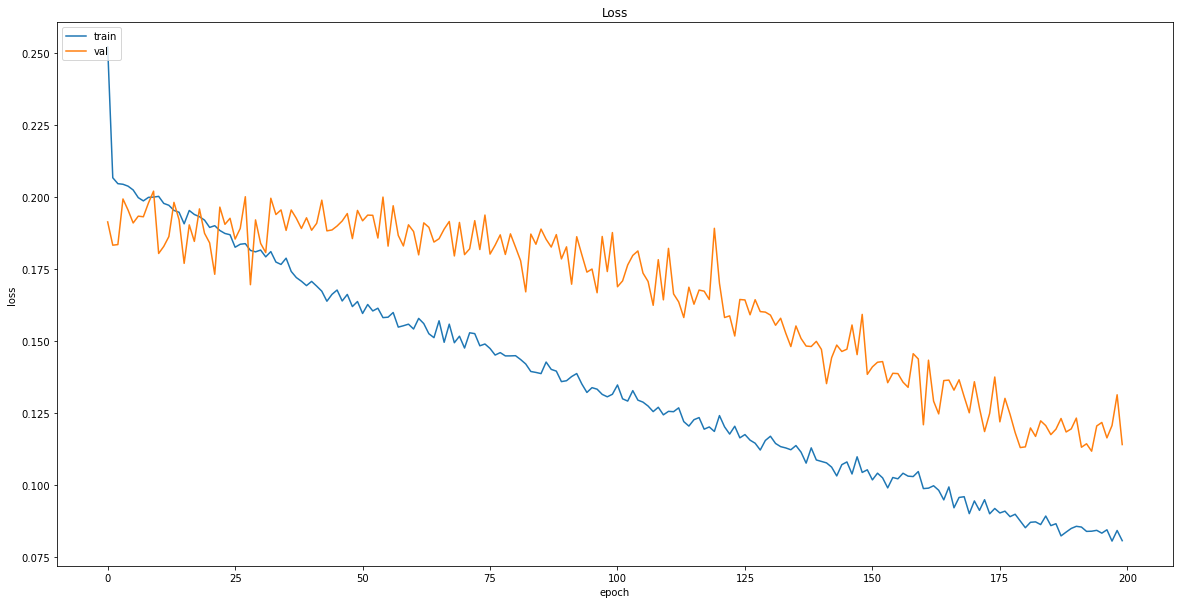

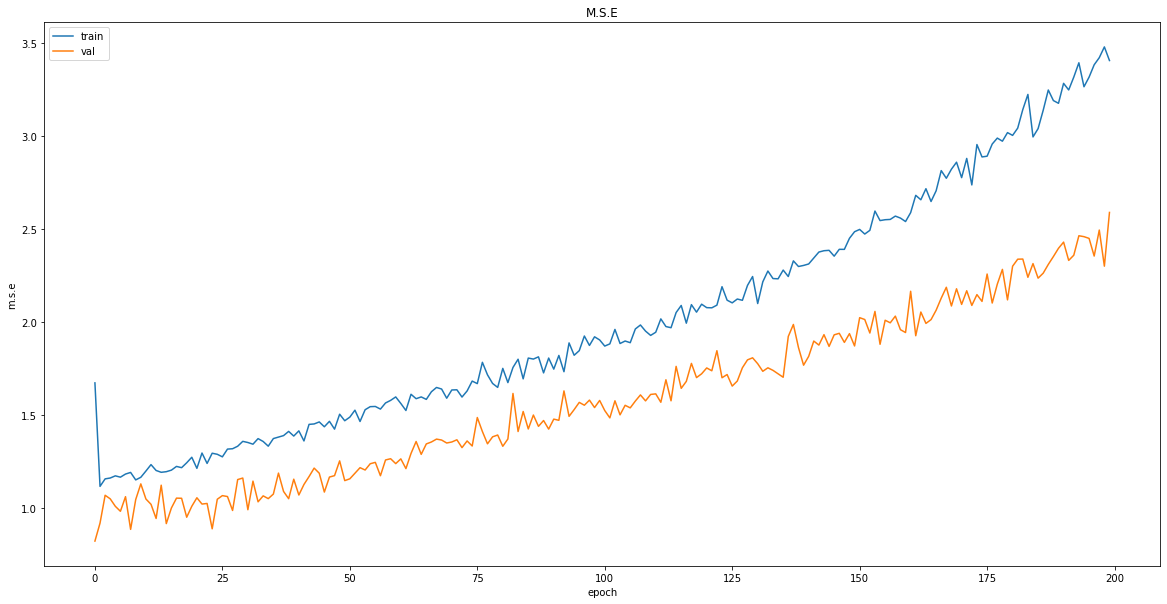

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
# Save model
model.save("models/{}".format('OCBC_image_cnn_buy_hold_sell_10.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/OCBC_image_cnn_buy_hold_sell_10.model\assets


### Test Performance

#### Non-Recession

In [34]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-28        11.47  11.498850 -69.642815  18673351.0     2.0
2019-01-29        11.52  11.502104 -60.714201  22001151.0     2.0
2019-01-30        11.40  11.486395 -82.142942  18573051.0     2.0
2019-01-31        11.39  11.471565 -83.928529  15623051.0     2.0
2019-02-01        11.51  11.477478 -62.499957  23129851.0     2.0


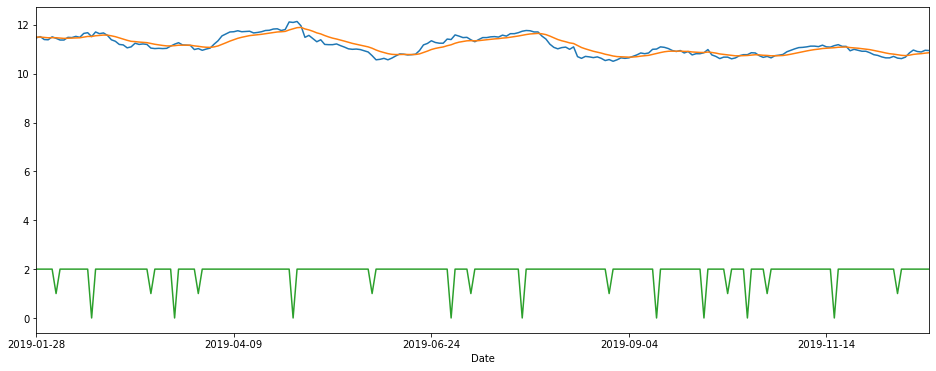

In [35]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [36]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_10_price = []
data_10_willr = []
data_10_ema = []
data_10_obv = []
count = 0

for i in df.values:
    if count == 9:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_price_arr = min_max_scaler.fit_transform(data_10_price)
        data_10_ema_arr = min_max_scaler.fit_transform(data_10_ema)
        data_10_willr_arr = min_max_scaler.fit_transform(data_10_willr)
        data_10_obv_arr = min_max_scaler.fit_transform(data_10_obv)
        price_data.append(data_10_price_arr)
        willr_data.append(data_10_willr_arr)
        ema_data.append(data_10_ema_arr)
        obv_data.append(data_10_obv_arr)
        labels.append(i[-1])
        data_10_price = data_10_price[1:]
        data_10_willr = data_10_willr[1:]
        data_10_obv = data_10_obv[1:]
        data_10_ema = data_10_ema[1:]
    
    else:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [38]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [39]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [40]:
model = tf.keras.models.load_model("models/OCBC_image_cnn_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 8ms/step - loss: 0.1047 - accuracy: 0.7706 - mean_squared_error: 2.7044 - weighted_accuracy: 0.7706 - weighted_mean_squared_error: 2.7044
Test loss: 0.10469778627157211
Test accuracy: 0.7706422209739685


In [41]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 179, 0: 24, 1: 15})

In [42]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 201, 0: 9, 1: 8})

In [43]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2019-02-11        11.53  11.457507 -67.857228  17615658.0     2.0   
2019-02-12        11.49  11.468659 -43.902530  20832858.0     2.0   
2019-02-13        11.65  11.471942 -42.424356  17325458.0     2.0   
2019-02-14        11.68  11.499336 -10.256417  22091358.0     2.0   
2019-02-15        11.52  11.527130  -5.714153  24228358.0     2.0   

            predictions  actual  
Date                             
2019-02-11            2       2  
2019-02-12            2       2  
2019-02-13            2       2  
2019-02-14            0       2  
2019-02-15            2       2

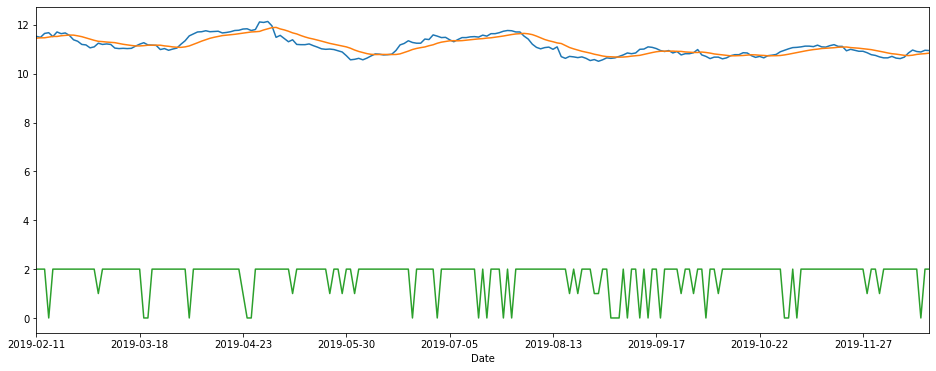

In [44]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

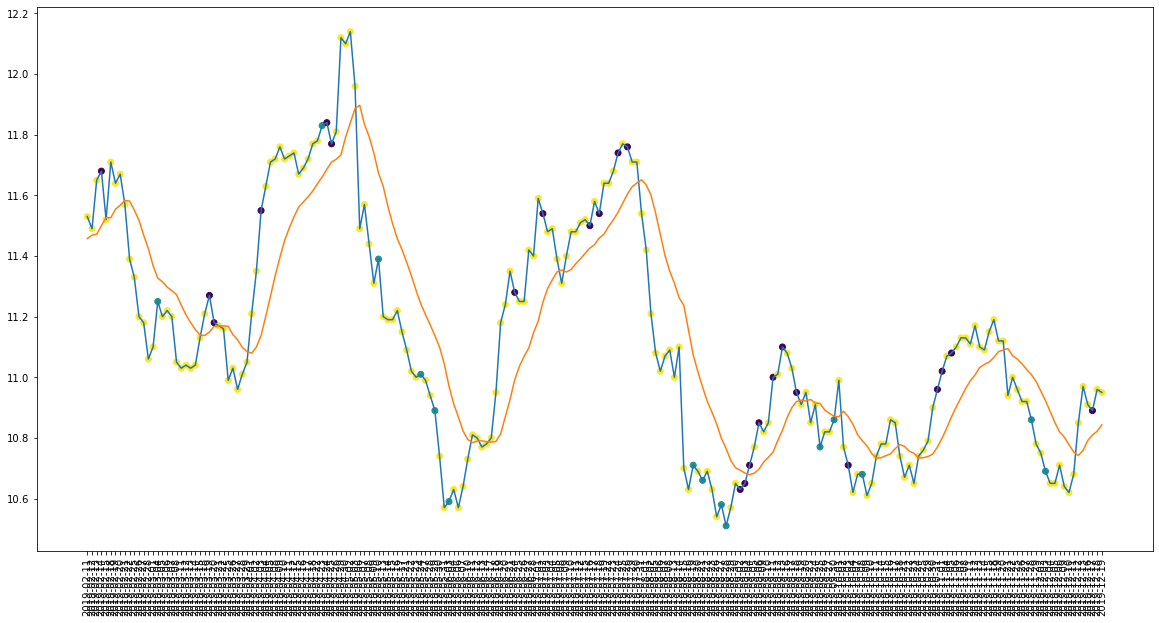

In [45]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

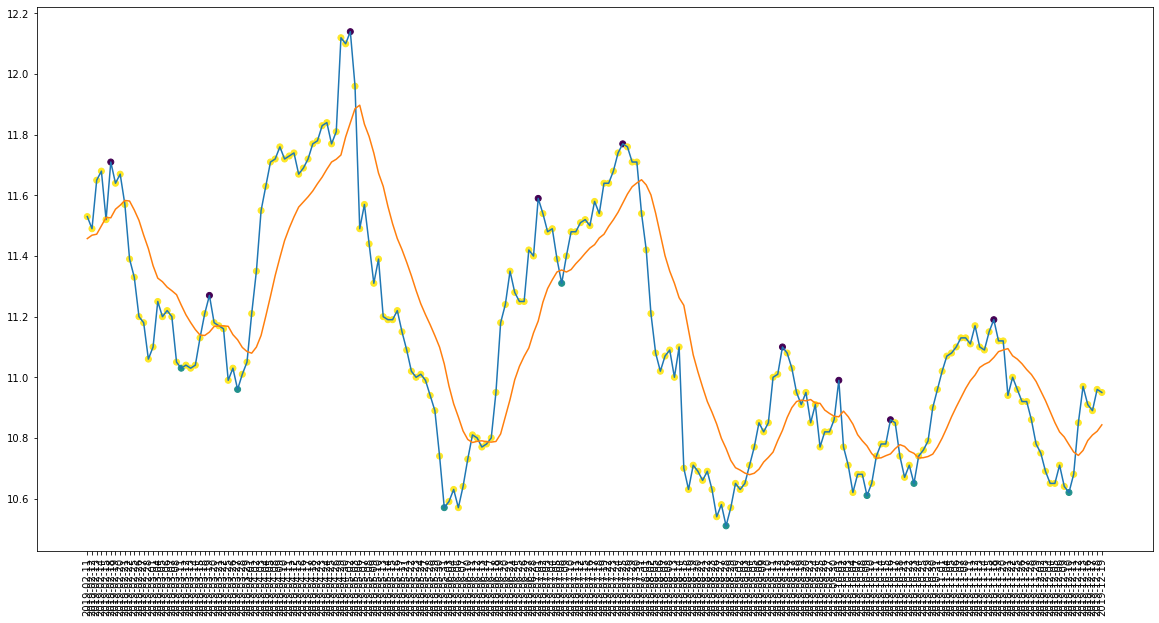

In [46]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [47]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 14
actual holds but predicted sell: 22
actual predicted holds: 165
Percentage buys correct: 12.5%
Percentage sells correct: 22.22222222222222%
Percentage holds correct: 82.08955223880596%
actual buys: 8
actual sells: 9
actual holds: 201


In [48]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[11.489999771118164, 11.520000457763672, 11.529999732971193, 11.56999969482422, 11.640000343322756, 11.649999618530273, 11.670000076293945, 11.68000030517578, 11.710000038146973]
[11.0600004196167, 11.100000381469727, 11.18000030517578, 11.199999809265137, 11.329999923706055, 11.390000343322756, 11.56999969482422, 11.640000343322756, 11.670000076293945]
Percentage buys correct: 40.0%
Percentage sells correct: 41.666666666666664%
Percentage holds correct: 86.51685393258427%


In [49]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $11.25
Shares owned at the moment: 886
Cash capital at the moment: $5.089374999999563


Stop Loss Activated!

Share price: $10.9399995803833
Shares owned at the moment: 0
Cash capital at the moment: $9671.273694242


Share price: $10.890000343322754
Shares owned at the moment: 885
Cash capital at the moment: $7.1198520657999325


Stop Loss Activated!

Share price: $10.56999969482422
Shares owned at the moment: 0
Cash capital at the moment: $9335.844845227957


Share price: $10.59000015258789
Shares owned at the moment: 879
Cash capital at the moment: $1.6360332343574555


Price increase from previously bought: 6.2234621593386885%
Share price: $11.279999732971193
Shares owned at the moment: 0
Cash capital at the moment: $9889.48921916151


Share price: $10.710000038146973
Shares owned at the moment: 920
Cash capital at the moment: $9.192883969782997




Capital at the end of test period: $10055.489208976267
profit gained: 0.5548920897626703%


In [50]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9445.467587005614
profit gained: -5.545324129943856%


#### Recession

In [51]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test2.csv")
df = df.iloc[5:]
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-30        10.91  11.040970 -69.565290  19391135.0     2.0
2020-01-31        10.92  11.022359 -67.391322  24795035.0     2.0
2020-02-03        10.83  10.992765 -83.333333  15850435.0     1.0
2020-02-04        10.71  10.949263 -98.113163   8263935.0     2.0
2020-02-05        10.85  10.933992 -71.697991  14379935.0     2.0


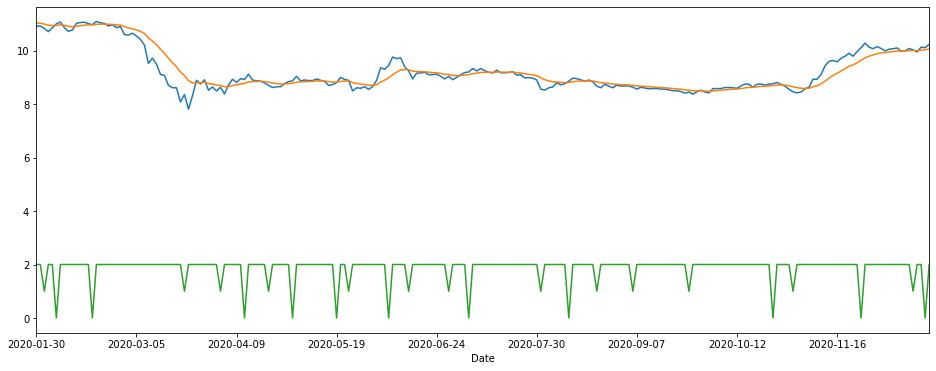

In [52]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [53]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_10_price = []
data_10_willr = []
data_10_ema = []
data_10_obv = []
count = 0

for i in df.values:
    if count == 9:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_price_arr = min_max_scaler.fit_transform(data_10_price)
        data_10_ema_arr = min_max_scaler.fit_transform(data_10_ema)
        data_10_willr_arr = min_max_scaler.fit_transform(data_10_willr)
        data_10_obv_arr = min_max_scaler.fit_transform(data_10_obv)
        price_data.append(data_10_price_arr)
        willr_data.append(data_10_willr_arr)
        ema_data.append(data_10_ema_arr)
        obv_data.append(data_10_obv_arr)
        labels.append(i[-1])
        data_10_price = data_10_price[1:]
        data_10_willr = data_10_willr[1:]
        data_10_obv = data_10_obv[1:]
        data_10_ema = data_10_ema[1:]
    
    else:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [55]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [56]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [57]:
model = tf.keras.models.load_model("models/OCBC_image_cnn_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 8ms/step - loss: 0.1086 - accuracy: 0.8093 - mean_squared_error: 2.5482 - weighted_accuracy: 0.8093 - weighted_mean_squared_error: 2.5482
Test loss: 0.10858786106109619
Test accuracy: 0.8093023300170898


In [58]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 192, 0: 11, 1: 12})

In [59]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 10, 1: 12})

In [60]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2020-02-12        11.02  10.890637 -80.357049  13333200.0     2.0   
2020-02-13        11.05  10.910539 -32.075322  21593100.0     2.0   
2020-02-14        11.06  10.931995 -15.217324  25962500.0     2.0   
2020-02-17        11.01  10.951688 -13.043361  29610200.0     2.0   
2020-02-18        10.97  10.960659 -23.912967  27996300.0     2.0   

            predictions  actual  
Date                             
2020-02-12            2       2  
2020-02-13            2       2  
2020-02-14            2       2  
2020-02-17            0       2  
2020-02-18            2       2

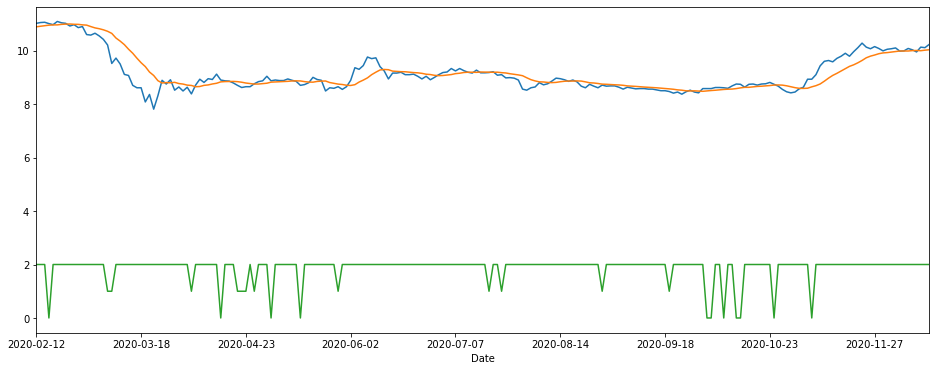

In [61]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

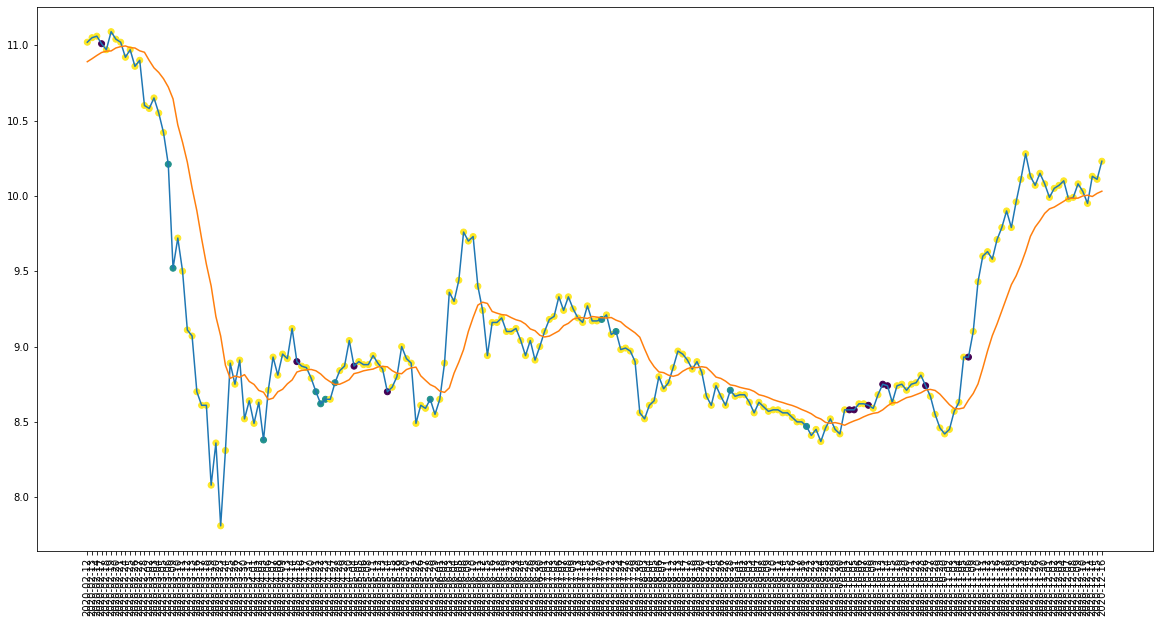

In [62]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

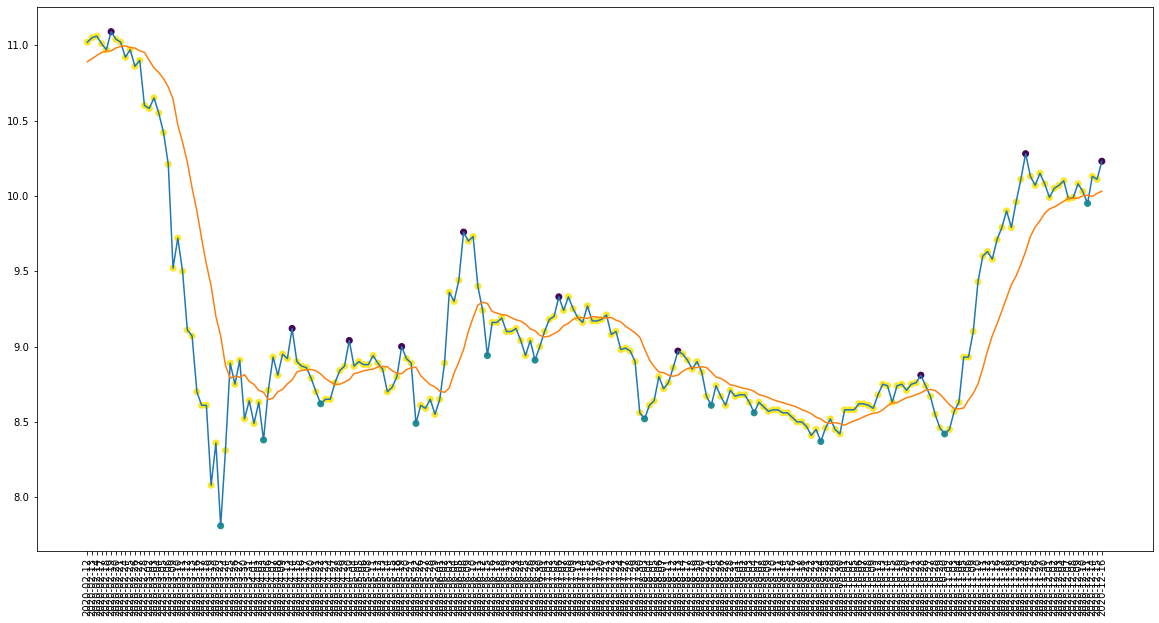

In [63]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [64]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 215
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 10
actual holds but predicted sell: 11
actual predicted holds: 172
Percentage buys correct: 16.666666666666668%
Percentage sells correct: 0.0%
Percentage holds correct: 89.11917098445596%
actual buys: 12
actual sells: 10
actual holds: 193


In [65]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[10.920000076293944, 10.970000267028807, 11.010000228881836, 11.020000457763672, 11.020000457763672, 11.039999961853027, 11.050000190734863, 11.0600004196167, 11.09000015258789]
[10.579999923706056, 10.600000381469727, 10.649999618530273, 10.859999656677246, 10.899999618530273, 10.920000076293944, 10.970000267028807, 11.020000457763672, 11.039999961853027]
Percentage buys correct: 41.666666666666664%
Percentage sells correct: 54.54545454545455%
Percentage holds correct: 86.38743455497382%


In [66]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $10.210000038146973
Shares owned at the moment: 976
Cash capital at the moment: $7.63632266616878


Stop Loss Activated!

Share price: $9.520000457763672
Shares owned at the moment: 0
Cash capital at the moment: $9273.605088214874


Share price: $9.520000457763672
Shares owned at the moment: 971
Cash capital at the moment: $4.263862504005374


Stop Loss Activated!

Share price: $9.109999656677246
Shares owned at the moment: 0
Cash capital at the moment: $8825.747552554369


Share price: $8.380000114440918
Shares owned at the moment: 1050
Cash capital at the moment: $2.550182060957013


Price increase from previously bought: 5.9139811459776315%
Share price: $8.899999618530273
Shares owned at the moment: 0
Cash capital at the moment: $9321.851032619237


Share price: $8.699999809265138
Shares owned at the moment: 1068
Cash capital at the moment: $4.699336884257718


Stop Loss Activated!

Share price: $8.409999847412111
Shares owned at the moment: 0
Cash capital at the moment

In [67]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9233.011672363282
profit gained: -7.669883276367181%


## CNOOC Limited

In [68]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14       OBV_7  labels
0  2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
1  2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2  2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
3  2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
4  2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


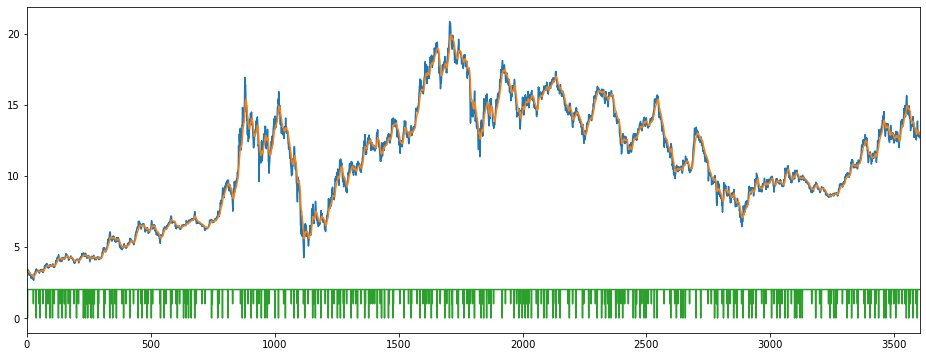

In [69]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [70]:
df.set_index('Date', inplace=True)
df.head()

previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0

In [71]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_10_price = []
data_10_willr = []
data_10_ema = []
data_10_obv = []
count = 0

for i in df.values:
    if count == 9:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_price_arr = min_max_scaler.fit_transform(data_10_price)
        data_10_ema_arr = min_max_scaler.fit_transform(data_10_ema)
        data_10_willr_arr = min_max_scaler.fit_transform(data_10_willr)
        data_10_obv_arr = min_max_scaler.fit_transform(data_10_obv)
        price_data.append(data_10_price_arr)
        willr_data.append(data_10_willr_arr)
        ema_data.append(data_10_ema_arr)
        obv_data.append(data_10_obv_arr)
        labels.append(i[-1])
        data_10_price = data_10_price[1:]
        data_10_willr = data_10_willr[1:]
        data_10_obv = data_10_obv[1:]
        data_10_ema = data_10_ema[1:]
    
    else:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        count += 1

In [72]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [74]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(3595, 64, 64, 1)

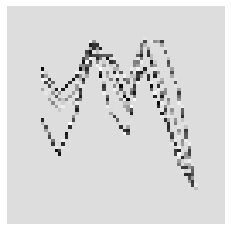

In [75]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [76]:
X = X/255

In [77]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [78]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [79]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [80]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [81]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[1 2 2 ... 2 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.262626262626263, 1: 7.374358974358974, 2: 0.3667431777607753}
Epoch 1/200
23/23 [==============================] - 2s 84ms/step - loss: 0.2463 - accuracy: 0.3720 - mse: 1.7210 - weighted_accuracy: 0.3373 - weighted_mse: 1.7544 - val_loss: 0.2220 - val_accuracy: 0.0445 - val_mse: 0.8997 - val_weighted_accuracy: 0.0445 - val_weighted_mse: 0.8997
Epoch 2/200
23/23 [==============================] - 0s 10ms/step - loss: 0.2094 - accuracy: 0.2031 - mse: 1.2141 - weighted_accuracy: 0.3293 - weighted_mse: 1.1866 - val_loss: 0.2057 - val_accuracy: 0.0445 - val_mse: 1.0659 - val_weighted_accuracy: 0.0445 - val_weighted_mse: 1.0659
Epoch 3/200
23/23 [==============================] - 0s 9ms/step - loss: 0.2067 - accuracy: 0.4183 - mse: 1.1428 - weighted_accuracy: 0.3326 - weighted_mse: 1.1695 - val_loss: 0.1946 - val_accuracy: 0.2281 - val_mse: 1.0050 - val_weighted_accuracy: 0.2281 - val_weighted_mse: 1.0050
Epoch 4/200
23/23 [==============================] - 0s 9ms/step - loss: 0.2058 -

23/23 [==============================] - 0s 9ms/step - loss: 0.1952 - accuracy: 0.2994 - mse: 1.2406 - weighted_accuracy: 0.4481 - weighted_mse: 1.2110 - val_loss: 0.1947 - val_accuracy: 0.0807 - val_mse: 1.0769 - val_weighted_accuracy: 0.0807 - val_weighted_mse: 1.0769
Epoch 29/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1928 - accuracy: 0.2531 - mse: 1.2657 - weighted_accuracy: 0.4534 - weighted_mse: 1.2119 - val_loss: 0.1956 - val_accuracy: 0.1363 - val_mse: 1.0174 - val_weighted_accuracy: 0.1363 - val_weighted_mse: 1.0174
Epoch 30/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1908 - accuracy: 0.2629 - mse: 1.2145 - weighted_accuracy: 0.4811 - weighted_mse: 1.1924 - val_loss: 0.1947 - val_accuracy: 0.0932 - val_mse: 1.0661 - val_weighted_accuracy: 0.0932 - val_weighted_mse: 1.0661
Epoch 31/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1906 - accuracy: 0.2413 - mse: 1.2114 - weighted_accuracy: 0.4875 - weighted_mse: 1.1

Epoch 57/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1655 - accuracy: 0.2337 - mse: 1.4007 - weighted_accuracy: 0.5981 - weighted_mse: 1.3994 - val_loss: 0.1982 - val_accuracy: 0.1558 - val_mse: 1.2200 - val_weighted_accuracy: 0.1558 - val_weighted_mse: 1.2200
Epoch 58/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1630 - accuracy: 0.2215 - mse: 1.4095 - weighted_accuracy: 0.6033 - weighted_mse: 1.3897 - val_loss: 0.2007 - val_accuracy: 0.1739 - val_mse: 1.1770 - val_weighted_accuracy: 0.1739 - val_weighted_mse: 1.1770
Epoch 59/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1653 - accuracy: 0.2344 - mse: 1.3743 - weighted_accuracy: 0.6128 - weighted_mse: 1.3695 - val_loss: 0.2026 - val_accuracy: 0.1599 - val_mse: 1.2657 - val_weighted_accuracy: 0.1599 - val_weighted_mse: 1.2657
Epoch 60/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1652 - accuracy: 0.2246 - mse: 1.4537 - weighted_accuracy: 0.5901 - weig

Epoch 86/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1480 - accuracy: 0.2816 - mse: 1.5944 - weighted_accuracy: 0.6617 - weighted_mse: 1.6873 - val_loss: 0.1940 - val_accuracy: 0.2893 - val_mse: 1.2897 - val_weighted_accuracy: 0.2893 - val_weighted_mse: 1.2897
Epoch 87/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1495 - accuracy: 0.2858 - mse: 1.5947 - weighted_accuracy: 0.6562 - weighted_mse: 1.6219 - val_loss: 0.1968 - val_accuracy: 0.2893 - val_mse: 1.2506 - val_weighted_accuracy: 0.2893 - val_weighted_mse: 1.2506
Epoch 88/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1478 - accuracy: 0.2823 - mse: 1.5874 - weighted_accuracy: 0.6524 - weighted_mse: 1.6416 - val_loss: 0.1979 - val_accuracy: 0.2643 - val_mse: 1.4223 - val_weighted_accuracy: 0.2643 - val_weighted_mse: 1.4223
Epoch 89/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1492 - accuracy: 0.2806 - mse: 1.5559 - weighted_accuracy: 0.6685 - weig

Epoch 115/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1317 - accuracy: 0.3519 - mse: 1.7630 - weighted_accuracy: 0.7117 - weighted_mse: 2.0158 - val_loss: 0.1911 - val_accuracy: 0.3282 - val_mse: 1.3094 - val_weighted_accuracy: 0.3282 - val_weighted_mse: 1.3094
Epoch 116/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1360 - accuracy: 0.3463 - mse: 1.7554 - weighted_accuracy: 0.7145 - weighted_mse: 1.9398 - val_loss: 0.1861 - val_accuracy: 0.3547 - val_mse: 1.4459 - val_weighted_accuracy: 0.3547 - val_weighted_mse: 1.4459
Epoch 117/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1299 - accuracy: 0.3748 - mse: 1.7944 - weighted_accuracy: 0.7297 - weighted_mse: 2.0818 - val_loss: 0.1856 - val_accuracy: 0.3574 - val_mse: 1.5117 - val_weighted_accuracy: 0.3574 - val_weighted_mse: 1.5117
Epoch 118/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1338 - accuracy: 0.3543 - mse: 1.7458 - weighted_accuracy: 0.7222 - 

Epoch 144/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1182 - accuracy: 0.5021 - mse: 2.0638 - weighted_accuracy: 0.7813 - weighted_mse: 2.5663 - val_loss: 0.1656 - val_accuracy: 0.5313 - val_mse: 1.6108 - val_weighted_accuracy: 0.5313 - val_weighted_mse: 1.6108
Epoch 145/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1180 - accuracy: 0.4944 - mse: 2.0624 - weighted_accuracy: 0.7736 - weighted_mse: 2.5647 - val_loss: 0.1614 - val_accuracy: 0.5494 - val_mse: 1.6386 - val_weighted_accuracy: 0.5494 - val_weighted_mse: 1.6386
Epoch 146/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1200 - accuracy: 0.5111 - mse: 2.1077 - weighted_accuracy: 0.7845 - weighted_mse: 2.6281 - val_loss: 0.1719 - val_accuracy: 0.4868 - val_mse: 1.4954 - val_weighted_accuracy: 0.4868 - val_weighted_mse: 1.4954
Epoch 147/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1246 - accuracy: 0.4704 - mse: 1.9868 - weighted_accuracy: 0.7457 - 

Epoch 173/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1011 - accuracy: 0.6175 - mse: 2.4467 - weighted_accuracy: 0.8332 - weighted_mse: 3.3199 - val_loss: 0.1408 - val_accuracy: 0.6843 - val_mse: 1.9434 - val_weighted_accuracy: 0.6843 - val_weighted_mse: 1.9434
Epoch 174/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1037 - accuracy: 0.6203 - mse: 2.5481 - weighted_accuracy: 0.8199 - weighted_mse: 3.4197 - val_loss: 0.1384 - val_accuracy: 0.7065 - val_mse: 1.9535 - val_weighted_accuracy: 0.7065 - val_weighted_mse: 1.9535
Epoch 175/200
23/23 [==============================] - 0s 9ms/step - loss: 0.0997 - accuracy: 0.6464 - mse: 2.4614 - weighted_accuracy: 0.8487 - weighted_mse: 3.3228 - val_loss: 0.1385 - val_accuracy: 0.6885 - val_mse: 1.9539 - val_weighted_accuracy: 0.6885 - val_weighted_mse: 1.9539
Epoch 176/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1051 - accuracy: 0.6481 - mse: 2.4888 - weighted_accuracy: 0.8299 - 

In [82]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12010898441076279
Test accuracy: 0.7593880295753479


In [83]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.6126787  -2.218427   -0.23557687]
 [-1.3616846  -1.5807679   0.00532714]
 [-1.3031943  -1.7382302   0.03463926]
 ...
 [-0.26523703 -3.119213   -0.43519816]
 [-1.0406506  -1.5409733  -0.02582388]
 [ 0.15323143 -3.357151   -0.7164337 ]]


Counter({2: 582, 0: 81, 1: 56})

In [84]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 654, 0: 33, 1: 32})

In [85]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 719
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 23
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 27
actual holds but predicted buy: 48
actual holds but predicted sell: 74
actual predicted holds: 532
Percentage buys correct: 25.0%
Percentage sells correct: 18.181818181818183%
Percentage holds correct: 81.34556574923548%
actual buys: 32
actual sells: 33
actual holds: 654


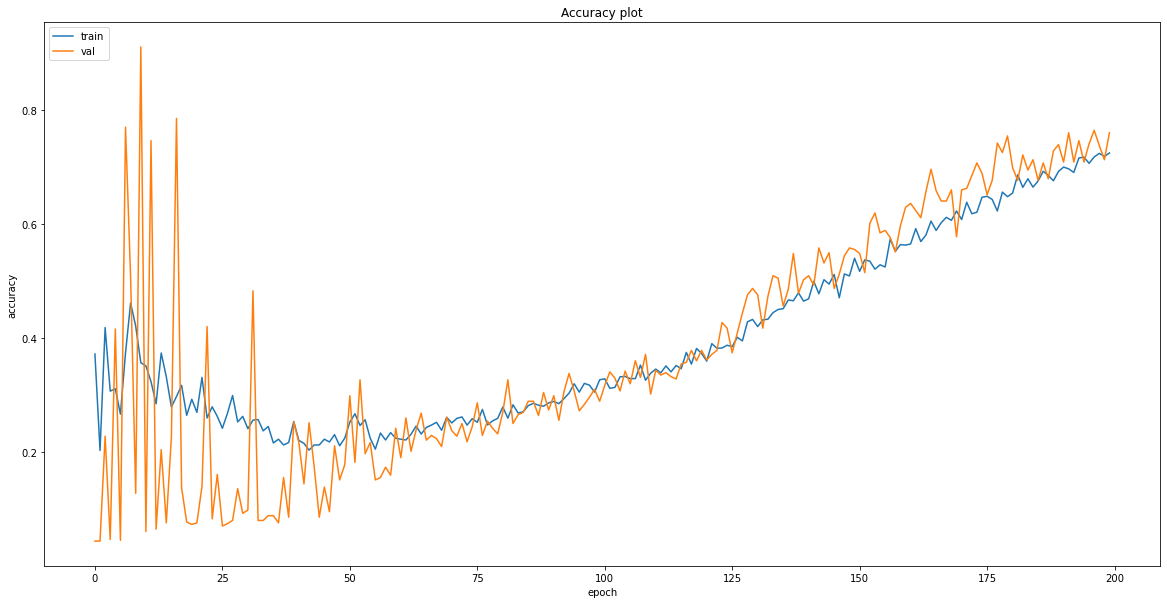

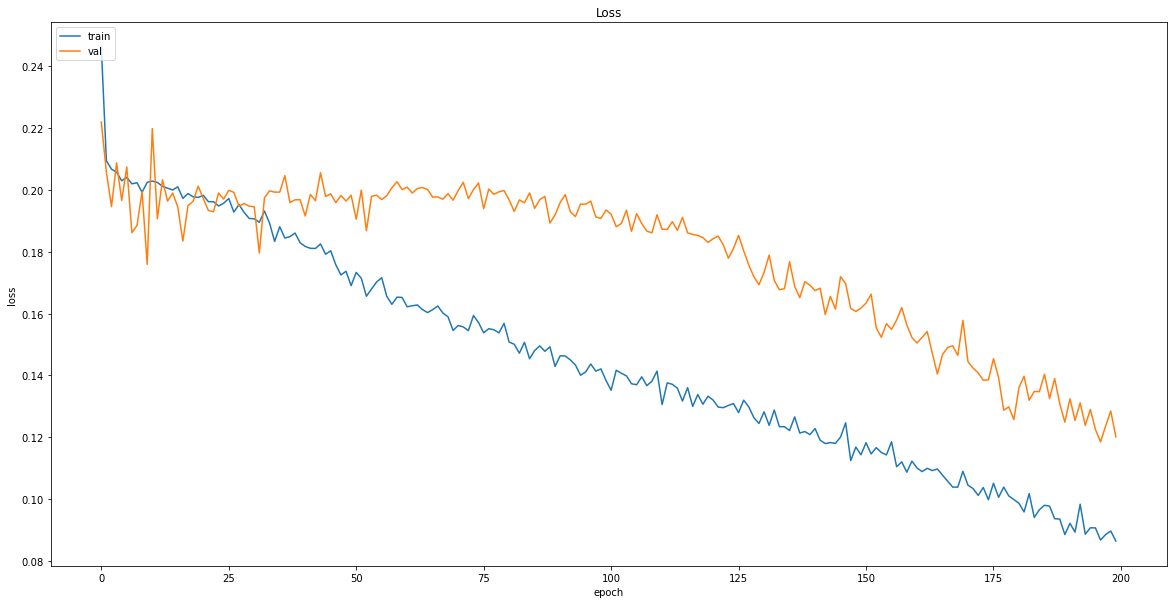

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [87]:
# Save model
model.save("models/{}".format('cnooc_image_cnn_buy_hold_sell_10.model'))

INFO:tensorflow:Assets written to: models/cnooc_image_cnn_buy_hold_sell_10.model\assets


### Test Performance

#### Non-Recession

In [88]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
df.head()

previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-29        13.04  12.757552 -13.725518  456517506.0     2.0
2019-01-30        12.64  12.739468 -52.941149  367199487.0     2.0
2019-01-31        12.80  12.748780 -37.254896  419227428.0     2.0
2019-02-01        13.12  12.805891  -5.882391  486899235.0     2.0
2019-02-04        13.22  12.869600  -6.818120  532291174.0     2.0

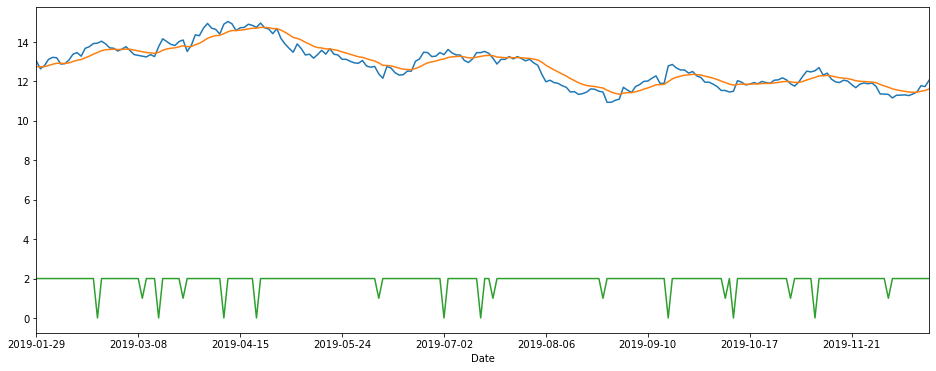

In [89]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [90]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_10_price = []
data_10_willr = []
data_10_ema = []
data_10_obv = []
count = 0

for i in df.values:
    if count == 9:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_price_arr = min_max_scaler.fit_transform(data_10_price)
        data_10_ema_arr = min_max_scaler.fit_transform(data_10_ema)
        data_10_willr_arr = min_max_scaler.fit_transform(data_10_willr)
        data_10_obv_arr = min_max_scaler.fit_transform(data_10_obv)
        price_data.append(data_10_price_arr)
        willr_data.append(data_10_willr_arr)
        ema_data.append(data_10_ema_arr)
        obv_data.append(data_10_obv_arr)
        labels.append(i[-1])
        data_10_price = data_10_price[1:]
        data_10_willr = data_10_willr[1:]
        data_10_obv = data_10_obv[1:]
        data_10_ema = data_10_ema[1:]
    
    else:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [92]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [93]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [94]:
model = tf.keras.models.load_model("models/cnooc_image_cnn_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 8ms/step - loss: 0.1232 - accuracy: 0.7773 - mean_squared_error: 2.4632 - weighted_accuracy: 0.7773 - weighted_mean_squared_error: 2.4632
Test loss: 0.12322110682725906
Test accuracy: 0.7772511839866638


In [95]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 175, 0: 17, 1: 19})

In [96]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [97]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14        OBV_7  labels  \
Date                                                                 
2019-02-14        13.46  13.005887  -9.090899  594167146.0     2.0   
2019-02-15        13.28  13.075751  -2.222168  636062191.0     2.0   
2019-02-18        13.68  13.107174 -22.222210  601994876.0     2.0   
2019-02-19        13.76  13.195301 -15.384598  654106730.0     2.0   
2019-02-20        13.92  13.282178  -9.230759  687559434.0     2.0   

            predictions  actual  
Date                             
2019-02-14            2       2  
2019-02-15            2       2  
2019-02-18            0       2  
2019-02-19            2       2  
2019-02-20            2       2

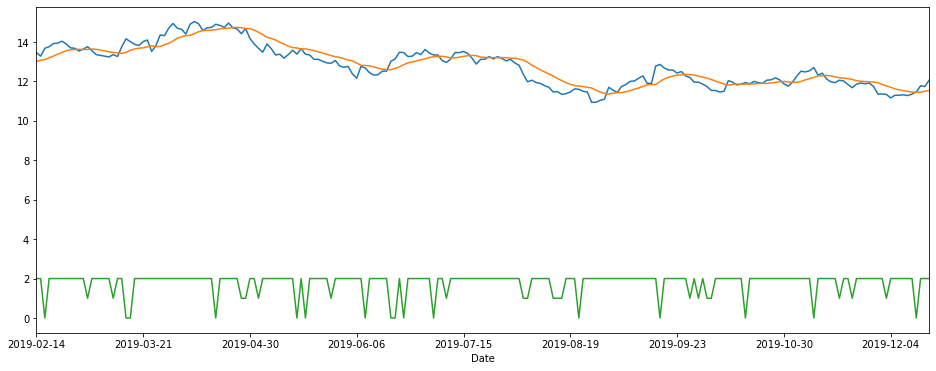

In [98]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

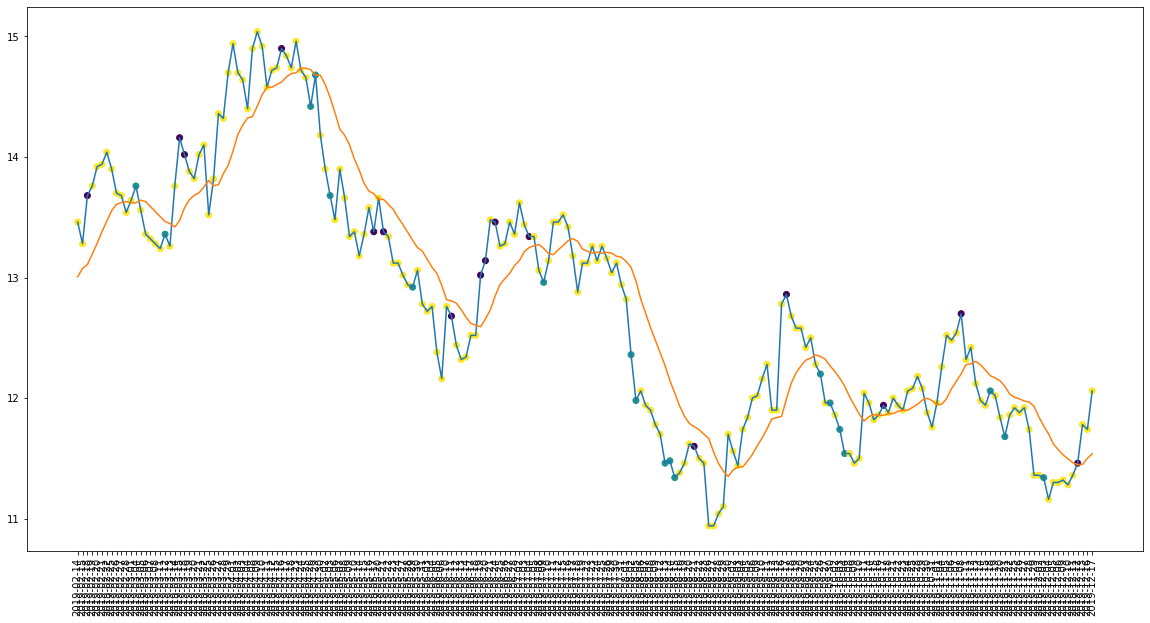

In [99]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

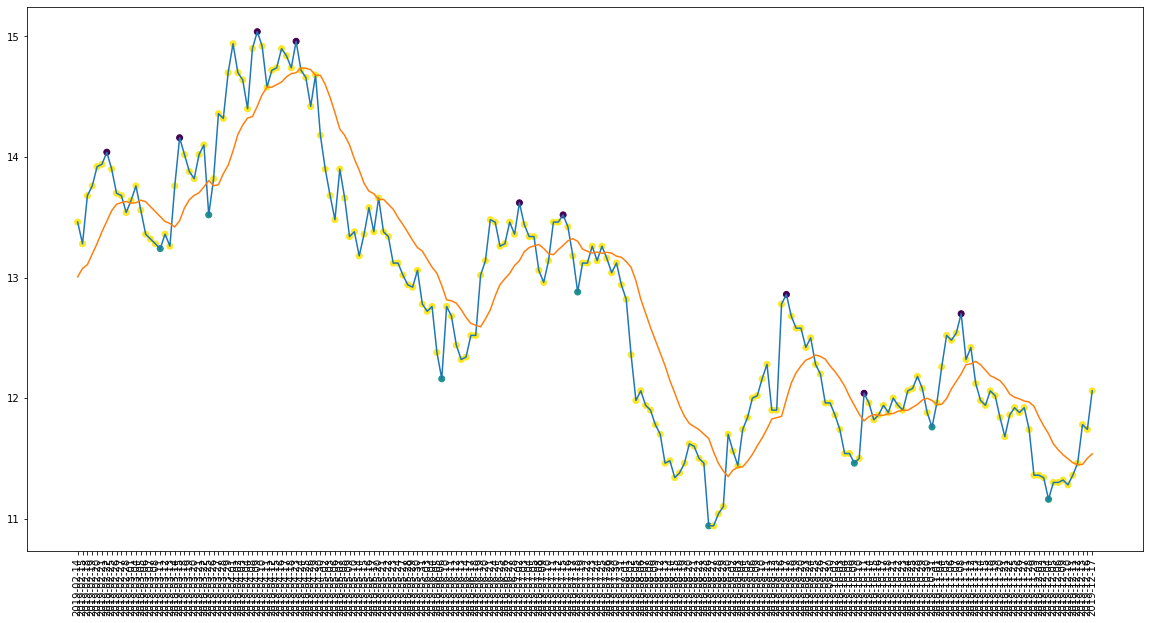

In [100]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [101]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 211
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 19
actual holds but predicted sell: 14
actual predicted holds: 161
Percentage buys correct: 0.0%
Percentage sells correct: 33.333333333333336%
Percentage holds correct: 82.98969072164948%
actual buys: 8
actual sells: 9
actual holds: 194


In [102]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[13.279999732971193, 13.460000038146973, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 13.920000076293945, 13.9399995803833, 14.039999961853027]
[13.359999656677244, 13.539999961853027, 13.5600004196167, 13.640000343322756, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 14.039999961853027]
Percentage buys correct: 47.36842105263158%
Percentage sells correct: 75.0%
Percentage holds correct: 82.85714285714286%


In [103]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $13.760000228881836
Shares owned at the moment: 724
Cash capital at the moment: $10.363673833846406


Stop Loss Activated!

Share price: $13.359999656677244
Shares owned at the moment: 0
Cash capital at the moment: $9656.403665951726


Share price: $13.359999656677244
Shares owned at the moment: 720
Cash capital at the moment: $10.751113823889682


Price increase from previously bought: 5.697357799682012%
Share price: $14.15999984741211
Shares owned at the moment: 0
Cash capital at the moment: $10177.914204262732


Share price: $14.420000076293945
Shares owned at the moment: 703
Cash capital at the moment: $12.776685480592278


Stop Loss Activated!

Share price: $13.899999618530273
Shares owned at the moment: 0
Cash capital at the moment: $9757.60424304485


Share price: $13.68000030517578
Shares owned at the moment: 711
Cash capital at the moment: $4.376205468177432


Stop Loss Activated!

Share price: $13.18000030517578
Shares owned at the moment: 0
Cash capital at the m

In [104]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8912.067081356048
profit gained: -10.879329186439518%


### Recession

In [105]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test2.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
df.head()

previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2020-01-31        12.00  12.977839 -94.680831  -24968864.0     2.0
2020-02-03        11.86  12.805864 -97.959186  -90556668.0     1.0
2020-02-04        11.68  12.632654 -96.330278 -150958086.0     2.0
2020-02-05        11.80  12.504553 -86.842095  -75225791.0     2.0
2020-02-06        12.00  12.426930 -76.851850   12002801.0     2.0

In [106]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_10_price = []
data_10_willr = []
data_10_ema = []
data_10_obv = []
count = 0

for i in df.values:
    if count == 9:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_price_arr = min_max_scaler.fit_transform(data_10_price)
        data_10_ema_arr = min_max_scaler.fit_transform(data_10_ema)
        data_10_willr_arr = min_max_scaler.fit_transform(data_10_willr)
        data_10_obv_arr = min_max_scaler.fit_transform(data_10_obv)
        price_data.append(data_10_price_arr)
        willr_data.append(data_10_willr_arr)
        ema_data.append(data_10_ema_arr)
        obv_data.append(data_10_obv_arr)
        labels.append(i[-1])
        data_10_price = data_10_price[1:]
        data_10_willr = data_10_willr[1:]
        data_10_obv = data_10_obv[1:]
        data_10_ema = data_10_ema[1:]
    
    else:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [107]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [108]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [109]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [110]:
model = tf.keras.models.load_model("models/cnooc_image_cnn_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 6ms/step - loss: 0.1167 - accuracy: 0.8075 - mean_squared_error: 2.3841 - weighted_accuracy: 0.8075 - weighted_mean_squared_error: 2.3841
Test loss: 0.11668004095554352
Test accuracy: 0.8075117468833923


In [111]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 17, 2: 178, 1: 18})

In [112]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [113]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14        OBV_7  labels  \
Date                                                                 
2020-02-13        12.34  12.385912 -50.526328  113135355.0     2.0   
2020-02-14        12.34  12.378849 -50.588221   60757697.0     2.0   
2020-02-17        12.26  12.372872 -46.153851   60757697.0     2.0   
2020-02-18        12.00  12.355507 -38.709648    5146960.0     2.0   
2020-02-19        12.08  12.300814 -59.677412  -52626865.0     2.0   

            predictions  actual  
Date                             
2020-02-13            0       2  
2020-02-14            2       2  
2020-02-17            0       2  
2020-02-18            2       2  
2020-02-19            2       2

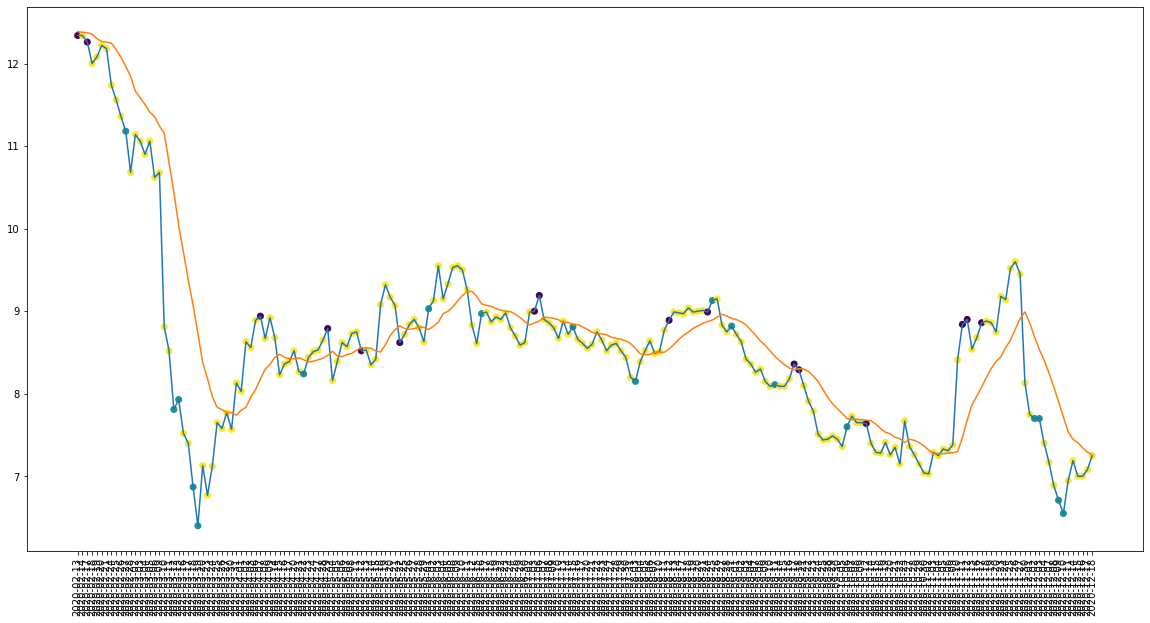

In [114]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

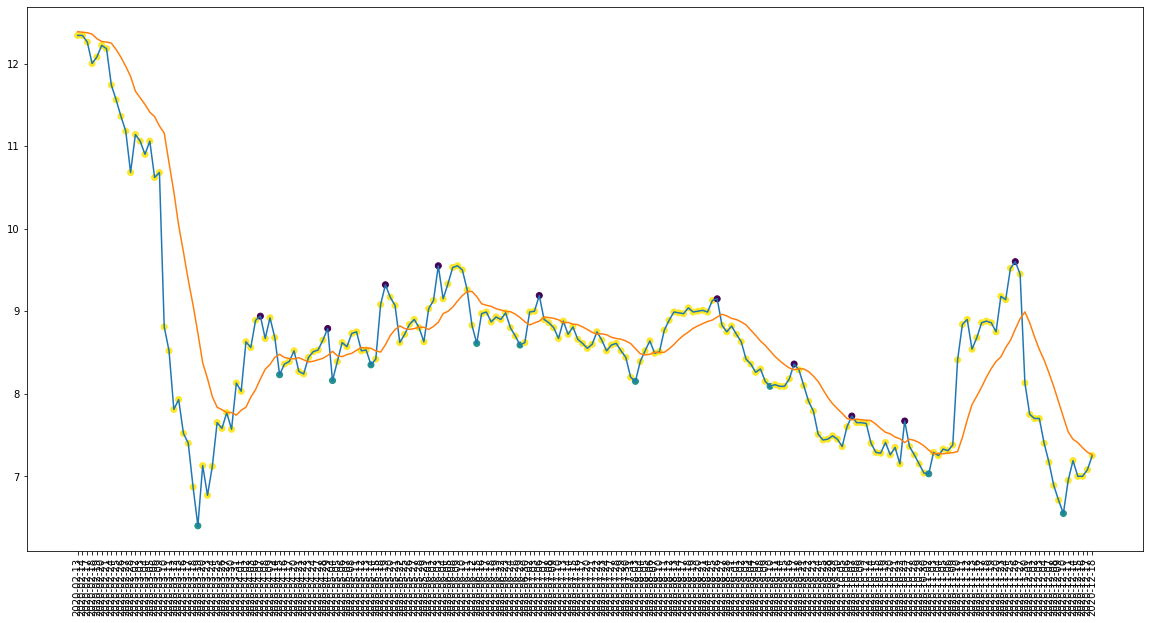

In [115]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [116]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 213
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 15
actual holds but predicted sell: 13
actual predicted holds: 165
Percentage buys correct: 30.0%
Percentage sells correct: 40.0%
Percentage holds correct: 85.49222797927462%
actual buys: 10
actual sells: 10
actual holds: 193


In [117]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[11.5600004196167, 11.739999771118164, 12.0, 12.079999923706055, 12.18000030517578, 12.220000267028807, 12.260000228881836, 12.34000015258789, 12.34000015258789]
[10.68000030517578, 10.899999618530273, 11.0600004196167, 11.140000343322754, 11.18000030517578, 11.359999656677244, 11.5600004196167, 11.739999771118164, 12.18000030517578]
Percentage buys correct: 50.0%
Percentage sells correct: 75.0%
Percentage holds correct: 85.95505617977528%


In [118]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $11.18000030517578
Shares owned at the moment: 892
Cash capital at the moment: $0.015187034608970862


Stop Loss Activated!

Share price: $10.68000030517578
Shares owned at the moment: 0
Cash capital at the moment: $9500.377418502807


Share price: $7.809999942779541
Shares owned at the moment: 1213
Cash capital at the moment: $0.7952806020966818


Stop Loss Activated!

Share price: $7.519999980926514
Shares owned at the moment: 0
Cash capital at the moment: $9097.470417529581


Share price: $6.869999885559082
Shares owned at the moment: 1320
Cash capital at the moment: $4.132469007012332


Stop Loss Activated!

Share price: $6.4000000953674325
Shares owned at the moment: 0
Cash capital at the moment: $8428.90059454584


Share price: $6.4000000953674325
Shares owned at the moment: 1313
Cash capital at the moment: $2.591668984052376


Price increase from previously bought: 39.30440425029494%
Share price: $8.9399995803833
Shares owned at the moment: 0
Cash capital at the mom

In [119]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5843.750896369933
profit gained: -41.56249103630067%


## JP Morgan

In [120]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
1  2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2  2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
3  2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
4  2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


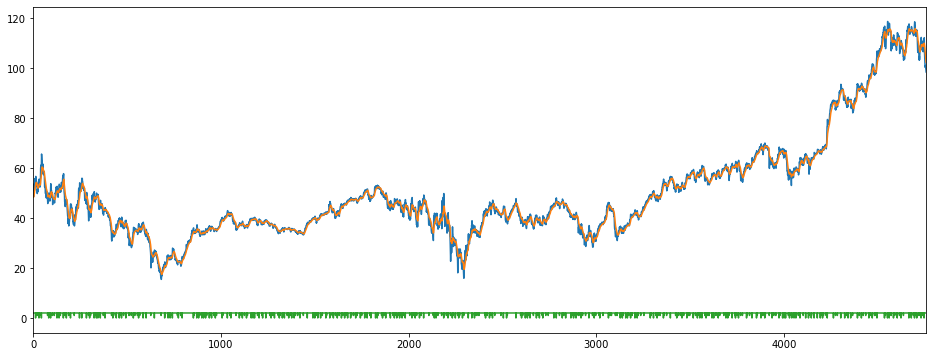

In [121]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [122]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0

In [123]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_10_price = []
data_10_willr = []
data_10_ema = []
data_10_obv = []
count = 0

for i in df.values:
    if count == 9:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_price_arr = min_max_scaler.fit_transform(data_10_price)
        data_10_ema_arr = min_max_scaler.fit_transform(data_10_ema)
        data_10_willr_arr = min_max_scaler.fit_transform(data_10_willr)
        data_10_obv_arr = min_max_scaler.fit_transform(data_10_obv)
        price_data.append(data_10_price_arr)
        willr_data.append(data_10_willr_arr)
        ema_data.append(data_10_ema_arr)
        obv_data.append(data_10_obv_arr)
        labels.append(i[-1])
        data_10_price = data_10_price[1:]
        data_10_willr = data_10_willr[1:]
        data_10_obv = data_10_obv[1:]
        data_10_ema = data_10_ema[1:]
    
    else:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        count += 1

In [124]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [125]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [126]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4750, 64, 64, 1)

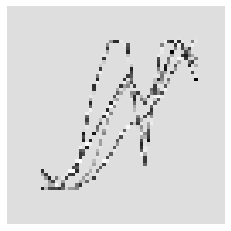

In [127]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [128]:
X = X/255

In [129]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [130]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [131]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [132]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [133]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.6767676767676765, 1: 7.407407407407407, 2: 0.36566589684372597}
Epoch 1/200
30/30 [==============================] - 3s 85ms/step - loss: 0.2431 - accuracy: 0.2961 - mse: 1.6076 - weighted_accuracy: 0.3191 - weighted_mse: 1.6577 - val_loss: 0.2141 - val_accuracy: 0.0526 - val_mse: 1.0132 - val_weighted_accuracy: 0.0526 - val_weighted_mse: 1.0132
Epoch 2/200
30/30 [==============================] - 0s 12ms/step - loss: 0.2029 - accuracy: 0.2789 - mse: 1.1860 - weighted_accuracy: 0.3730 - weighted_mse: 1.1727 - val_loss: 0.2218 - val_accuracy: 0.0621 - val_mse: 0.8738 - val_weighted_accuracy: 0.0621 - val_weighted_mse: 0.8738
Epoch 3/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2040 - accuracy: 0.2203 - mse: 1.2641 - weighted_accuracy: 0.3502 - weighted_mse: 1.2258 - val_loss: 0.2073 - val_accuracy: 0.0453 - val_mse: 0.9591 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.9591
Epoch 4/200
30/30 [==============================] - 0s 10ms/step - loss: 0.20

30/30 [==============================] - 0s 9ms/step - loss: 0.1798 - accuracy: 0.1795 - mse: 1.3525 - weighted_accuracy: 0.5294 - weighted_mse: 1.2977 - val_loss: 0.2040 - val_accuracy: 0.0705 - val_mse: 1.1540 - val_weighted_accuracy: 0.0705 - val_weighted_mse: 1.1540
Epoch 29/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1784 - accuracy: 0.1934 - mse: 1.3584 - weighted_accuracy: 0.5422 - weighted_mse: 1.3155 - val_loss: 0.2048 - val_accuracy: 0.0716 - val_mse: 1.2383 - val_weighted_accuracy: 0.0716 - val_weighted_mse: 1.2383
Epoch 30/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1788 - accuracy: 0.1779 - mse: 1.4042 - weighted_accuracy: 0.5284 - weighted_mse: 1.3495 - val_loss: 0.2026 - val_accuracy: 0.0695 - val_mse: 1.1752 - val_weighted_accuracy: 0.0695 - val_weighted_mse: 1.1752
Epoch 31/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1798 - accuracy: 0.1942 - mse: 1.3809 - weighted_accuracy: 0.5362 - weighted_mse: 1.

Epoch 57/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1609 - accuracy: 0.2026 - mse: 1.5542 - weighted_accuracy: 0.6097 - weighted_mse: 1.4843 - val_loss: 0.2019 - val_accuracy: 0.1158 - val_mse: 1.2225 - val_weighted_accuracy: 0.1158 - val_weighted_mse: 1.2225
Epoch 58/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1647 - accuracy: 0.1945 - mse: 1.5000 - weighted_accuracy: 0.5879 - weighted_mse: 1.4360 - val_loss: 0.2043 - val_accuracy: 0.1211 - val_mse: 1.3395 - val_weighted_accuracy: 0.1211 - val_weighted_mse: 1.3395
Epoch 59/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1620 - accuracy: 0.1942 - mse: 1.5833 - weighted_accuracy: 0.5913 - weighted_mse: 1.5108 - val_loss: 0.2030 - val_accuracy: 0.1242 - val_mse: 1.2243 - val_weighted_accuracy: 0.1242 - val_weighted_mse: 1.2243
Epoch 60/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1597 - accuracy: 0.2016 - mse: 1.5340 - weighted_accuracy: 0.6074 - we

Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1434 - accuracy: 0.2295 - mse: 1.7202 - weighted_accuracy: 0.6593 - weighted_mse: 1.7551 - val_loss: 0.2079 - val_accuracy: 0.1632 - val_mse: 1.6145 - val_weighted_accuracy: 0.1632 - val_weighted_mse: 1.6145
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1403 - accuracy: 0.2413 - mse: 1.7686 - weighted_accuracy: 0.6770 - weighted_mse: 1.8359 - val_loss: 0.2048 - val_accuracy: 0.1768 - val_mse: 1.5507 - val_weighted_accuracy: 0.1768 - val_weighted_mse: 1.5507
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1426 - accuracy: 0.2500 - mse: 1.7792 - weighted_accuracy: 0.6763 - weighted_mse: 1.8418 - val_loss: 0.2043 - val_accuracy: 0.1737 - val_mse: 1.5955 - val_weighted_accuracy: 0.1737 - val_weighted_mse: 1.5955
Epoch 89/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1441 - accuracy: 0.2468 - mse: 1.7551 - weighted_accuracy: 0.6732 - weig

Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1307 - accuracy: 0.3574 - mse: 2.0009 - weighted_accuracy: 0.7197 - weighted_mse: 2.2449 - val_loss: 0.1868 - val_accuracy: 0.3442 - val_mse: 1.6697 - val_weighted_accuracy: 0.3442 - val_weighted_mse: 1.6697
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1289 - accuracy: 0.3739 - mse: 1.8954 - weighted_accuracy: 0.7235 - weighted_mse: 2.1442 - val_loss: 0.1901 - val_accuracy: 0.3295 - val_mse: 1.7365 - val_weighted_accuracy: 0.3295 - val_weighted_mse: 1.7365
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1286 - accuracy: 0.3858 - mse: 1.9550 - weighted_accuracy: 0.7147 - weighted_mse: 2.2049 - val_loss: 0.1955 - val_accuracy: 0.3200 - val_mse: 1.8461 - val_weighted_accuracy: 0.3200 - val_weighted_mse: 1.8461
Epoch 118/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1282 - accuracy: 0.3650 - mse: 2.0064 - weighted_accuracy: 0.7204 - 

Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1129 - accuracy: 0.5182 - mse: 2.2456 - weighted_accuracy: 0.7746 - weighted_mse: 2.9250 - val_loss: 0.1703 - val_accuracy: 0.5263 - val_mse: 2.0123 - val_weighted_accuracy: 0.5263 - val_weighted_mse: 2.0123
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1135 - accuracy: 0.5224 - mse: 2.3192 - weighted_accuracy: 0.7718 - weighted_mse: 2.9229 - val_loss: 0.1768 - val_accuracy: 0.4821 - val_mse: 2.0811 - val_weighted_accuracy: 0.4821 - val_weighted_mse: 2.0811
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1103 - accuracy: 0.5111 - mse: 2.3001 - weighted_accuracy: 0.7851 - weighted_mse: 3.0656 - val_loss: 0.1748 - val_accuracy: 0.5147 - val_mse: 2.0311 - val_weighted_accuracy: 0.5147 - val_weighted_mse: 2.0311
Epoch 147/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1105 - accuracy: 0.5250 - mse: 2.2404 - weighted_accuracy: 0.7674 - 

Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0982 - accuracy: 0.6434 - mse: 2.6692 - weighted_accuracy: 0.8127 - weighted_mse: 3.8379 - val_loss: 0.1534 - val_accuracy: 0.6284 - val_mse: 2.3191 - val_weighted_accuracy: 0.6284 - val_weighted_mse: 2.3191
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0973 - accuracy: 0.6161 - mse: 2.6374 - weighted_accuracy: 0.8081 - weighted_mse: 3.7747 - val_loss: 0.1522 - val_accuracy: 0.6158 - val_mse: 2.1772 - val_weighted_accuracy: 0.6158 - val_weighted_mse: 2.1772
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0930 - accuracy: 0.6458 - mse: 2.7338 - weighted_accuracy: 0.8267 - weighted_mse: 3.8877 - val_loss: 0.1498 - val_accuracy: 0.6368 - val_mse: 2.2307 - val_weighted_accuracy: 0.6368 - val_weighted_mse: 2.2307
Epoch 176/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0909 - accuracy: 0.6795 - mse: 2.7179 - weighted_accuracy: 0.8239 - 

In [134]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12126181274652481
Test accuracy: 0.7631579041481018


In [135]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.5040214  -0.23653412 -0.54171   ]
 [-1.8992624  -0.6320616  -0.3035421 ]
 [-0.14951591 -2.9894526  -0.51420254]
 ...
 [-2.0435905  -1.3371212   0.1181899 ]
 [-0.49876913 -2.824631   -0.30262807]
 [-2.2793136  -0.4616843  -0.35120302]]


Counter({1: 75, 2: 788, 0: 87})

In [136]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 866, 0: 41, 1: 43})

In [137]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 950
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 36
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 36
actual holds but predicted buy: 69
actual holds but predicted sell: 81
actual predicted holds: 716
Percentage buys correct: 11.627906976744185%
Percentage sells correct: 9.75609756097561%
Percentage holds correct: 82.67898383371825%
actual buys: 43
actual sells: 41
actual holds: 866


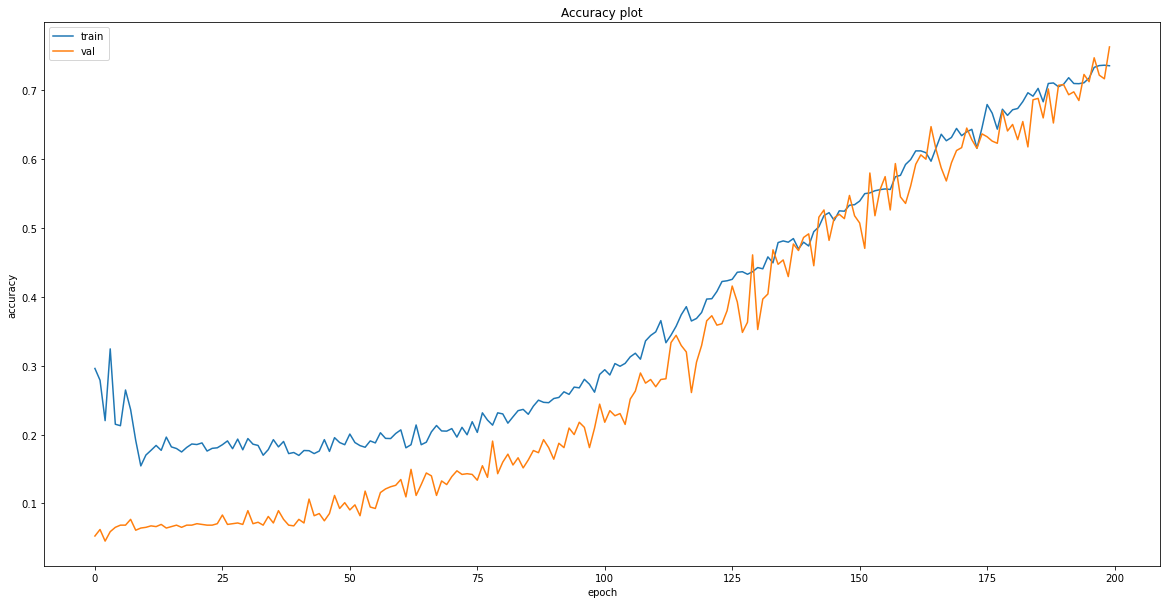

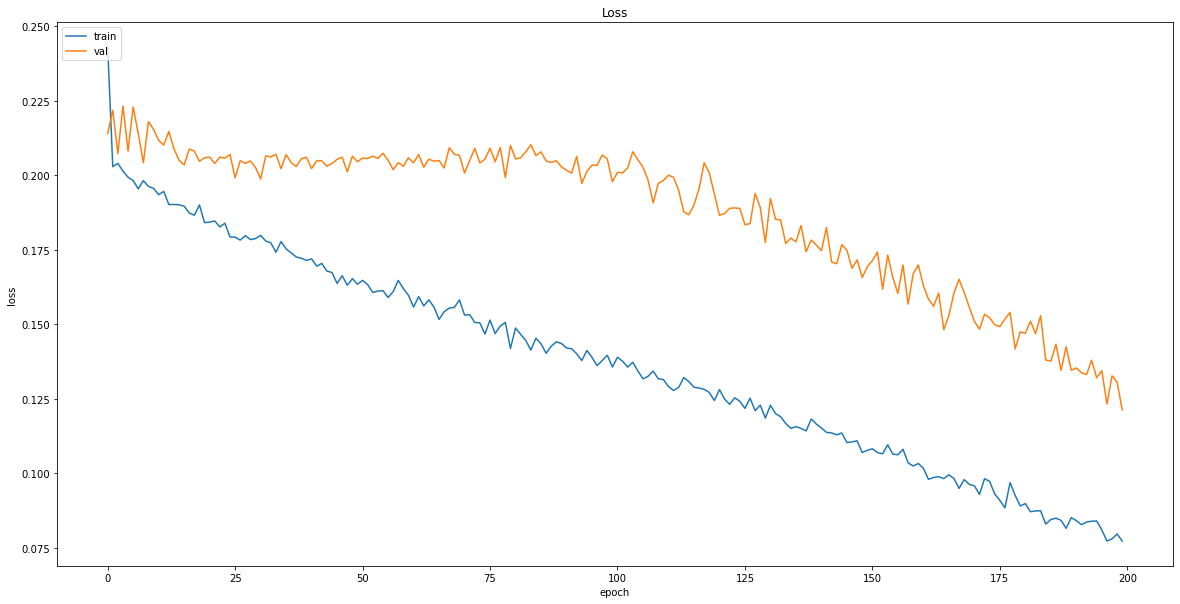

In [138]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [139]:
# Save model
model.save("models/{}".format('jpm_image_cnn_buy_hold_sell_10.model'))

INFO:tensorflow:Assets written to: models/jpm_image_cnn_buy_hold_sell_10.model\assets


### Test Performance

### non-recession

In [140]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
df.head()

previous_1d      EMA_12   willr_14        OBV_7  labels
Date                                                               
2019-01-29   103.879997  102.341518 -16.190536   93054100.0     2.0
2019-01-30   104.169998  102.622823 -14.439357  102797400.0     2.0
2019-01-31   104.410004  102.897774 -12.499914  115323700.0     2.0
2019-02-01   103.500000  102.990424 -26.204790   97803100.0     2.0
2019-02-04   103.879997  103.127281 -20.481939  110803900.0     2.0

In [141]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_10_price = []
data_10_willr = []
data_10_ema = []
data_10_obv = []
count = 0

for i in df.values:
    if count == 9:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_price_arr = min_max_scaler.fit_transform(data_10_price)
        data_10_ema_arr = min_max_scaler.fit_transform(data_10_ema)
        data_10_willr_arr = min_max_scaler.fit_transform(data_10_willr)
        data_10_obv_arr = min_max_scaler.fit_transform(data_10_obv)
        price_data.append(data_10_price_arr)
        willr_data.append(data_10_willr_arr)
        ema_data.append(data_10_ema_arr)
        obv_data.append(data_10_obv_arr)
        labels.append(i[-1])
        data_10_price = data_10_price[1:]
        data_10_willr = data_10_willr[1:]
        data_10_obv = data_10_obv[1:]
        data_10_ema = data_10_ema[1:]
    
    else:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [142]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [143]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [144]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [145]:
model = tf.keras.models.load_model("models/jpm_image_cnn_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1222 - accuracy: 0.7477 - mean_squared_error: 2.5256 - weighted_accuracy: 0.7477 - weighted_mean_squared_error: 2.5256
Test loss: 0.12218410521745682
Test accuracy: 0.747706413269043


In [146]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 171, 0: 29, 1: 18})

In [147]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [148]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d      EMA_12   willr_14       OBV_7  labels  \
Date                                                                 
2019-02-11   100.879997  102.975915 -74.903417  73097300.0     1.0   
2019-02-12   102.599998  102.653466 -84.169891  62118800.0     2.0   
2019-02-13   103.089996  102.645240 -50.965236  74971100.0     2.0   
2019-02-14   102.419998  102.713664 -41.505819  85725200.0     2.0   
2019-02-15   105.550003  102.668485 -54.440145  74206700.0     2.0   

            predictions  actual  
Date                             
2019-02-11            2       1  
2019-02-12            2       2  
2019-02-13            2       2  
2019-02-14            2       2  
2019-02-15            2       2

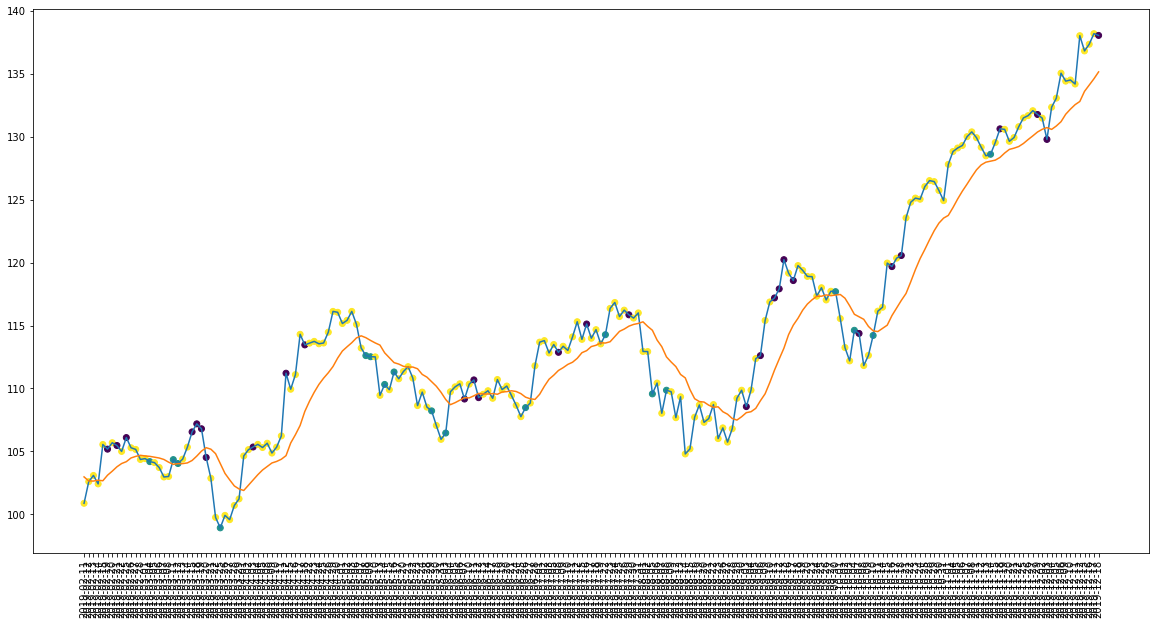

In [149]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

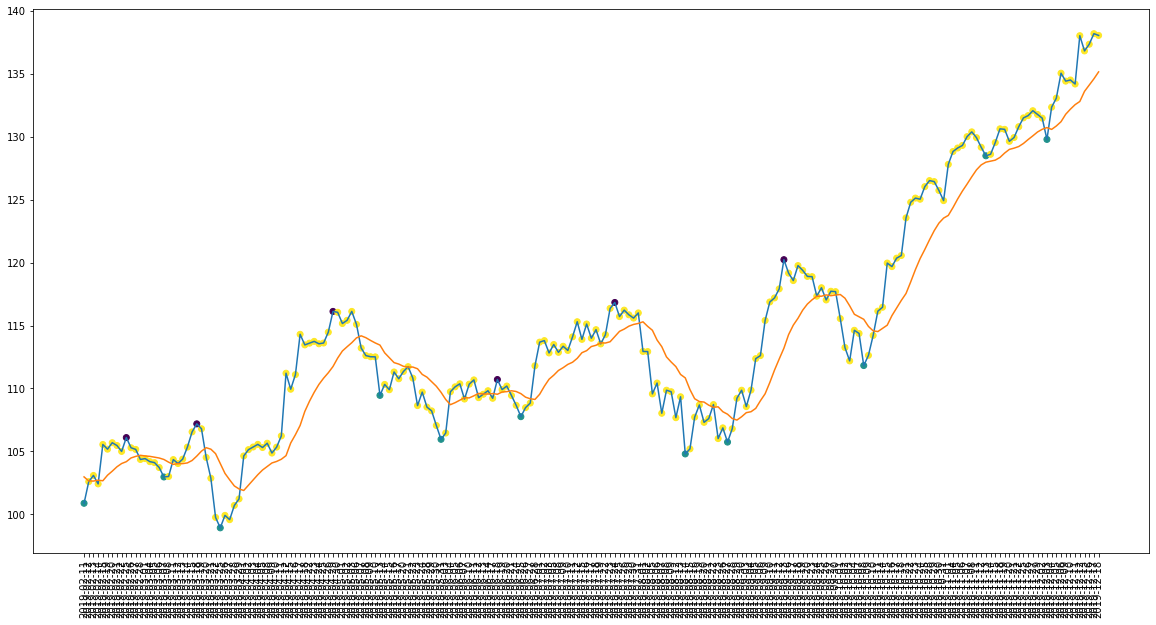

In [150]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [151]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 3
actual holds but predicted buy: 17
actual holds but predicted sell: 25
actual predicted holds: 159
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 50.0%
Percentage holds correct: 79.1044776119403%
actual buys: 11
actual sells: 6
actual holds: 201


In [152]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[100.87999725341795, 102.41999816894531, 102.5999984741211, 103.08999633789062, 105.0, 105.18000030517578, 105.47000122070312, 105.5500030517578, 105.69000244140624]
[104.19000244140624, 104.36000061035156, 104.43000030517578, 105.0, 105.16000366210938, 105.29000091552734, 105.47000122070312, 105.69000244140624, 106.0999984741211]
Percentage buys correct: 55.55555555555556%
Percentage sells correct: 48.275862068965516%
Percentage holds correct: 85.29411764705883%


In [153]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $104.19000244140624
Shares owned at the moment: 95
Cash capital at the moment: $74.73012992859003


Stop Loss Activated!

Share price: $99.76000213623048
Shares owned at the moment: 0
Cash capital at the moment: $9525.868032312395


Share price: $98.93000030517578
Shares owned at the moment: 96
Cash capital at the moment: $2.470482934953907


Price increase from previously bought: 6.197392276003066%
Share price: $105.3499984741211
Shares owned at the moment: 0
Cash capital at the moment: $10088.25793685341


Share price: $112.61000061035156
Shares owned at the moment: 89
Cash capital at the moment: $38.40658488273766


Stop Loss Activated!

Share price: $109.4499969482422
Shares owned at the moment: 0
Cash capital at the moment: $9752.668426523212


Share price: $110.31999969482422
Shares owned at the moment: 88
Cash capital at the moment: $17.811013452534098


Stop Loss Activated!

Share price: $107.05999755859376
Shares owned at the moment: 0
Cash capital at the moment: 

In [154]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $13577.290673755644
profit gained: 35.77290673755644%


### recession

In [155]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test2.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
df.head()

previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-29   134.429993  135.764759 -57.285148   1917800.0     2.0
2020-01-30   134.229996  135.528641 -59.095077  -7408200.0     2.0
2020-01-31   135.889999  135.584235 -44.072403   1640700.0     2.0
2020-02-03   132.360001  135.088199 -76.018128 -11144500.0     2.0
2020-02-04   133.369995  134.823860 -66.877896  -1123400.0     2.0

In [156]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_10_price = []
data_10_willr = []
data_10_ema = []
data_10_obv = []
count = 0

for i in df.values:
    if count == 9:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_price_arr = min_max_scaler.fit_transform(data_10_price)
        data_10_ema_arr = min_max_scaler.fit_transform(data_10_ema)
        data_10_willr_arr = min_max_scaler.fit_transform(data_10_willr)
        data_10_obv_arr = min_max_scaler.fit_transform(data_10_obv)
        price_data.append(data_10_price_arr)
        willr_data.append(data_10_willr_arr)
        ema_data.append(data_10_ema_arr)
        obv_data.append(data_10_obv_arr)
        labels.append(i[-1])
        data_10_price = data_10_price[1:]
        data_10_willr = data_10_willr[1:]
        data_10_obv = data_10_obv[1:]
        data_10_ema = data_10_ema[1:]
    
    else:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [157]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [158]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [159]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [160]:
model = tf.keras.models.load_model("models/jpm_image_cnn_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 7ms/step - loss: 0.1241 - accuracy: 0.7397 - mean_squared_error: 2.5890 - weighted_accuracy: 0.7397 - weighted_mean_squared_error: 2.5890
Test loss: 0.12410983443260193
Test accuracy: 0.7397260069847107


In [161]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 26, 2: 173, 1: 20})

In [162]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [163]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d      EMA_12   willr_14       OBV_7  labels  \
Date                                                                 
2020-02-11   138.000000  136.179383  -6.410124  26757600.0     0.0   
2020-02-12   138.000000  136.459478  -9.001177  33336200.0     2.0   
2020-02-13   137.880005  136.696481 -13.465502  33336200.0     2.0   
2020-02-14   137.460007  136.878562 -14.718062  25888700.0     2.0   
2020-02-18   135.639999  136.968015 -23.401387  19261100.0     2.0   

            predictions  actual  
Date                             
2020-02-11            0       0  
2020-02-12            2       2  
2020-02-13            2       2  
2020-02-14            2       2  
2020-02-18            2       2

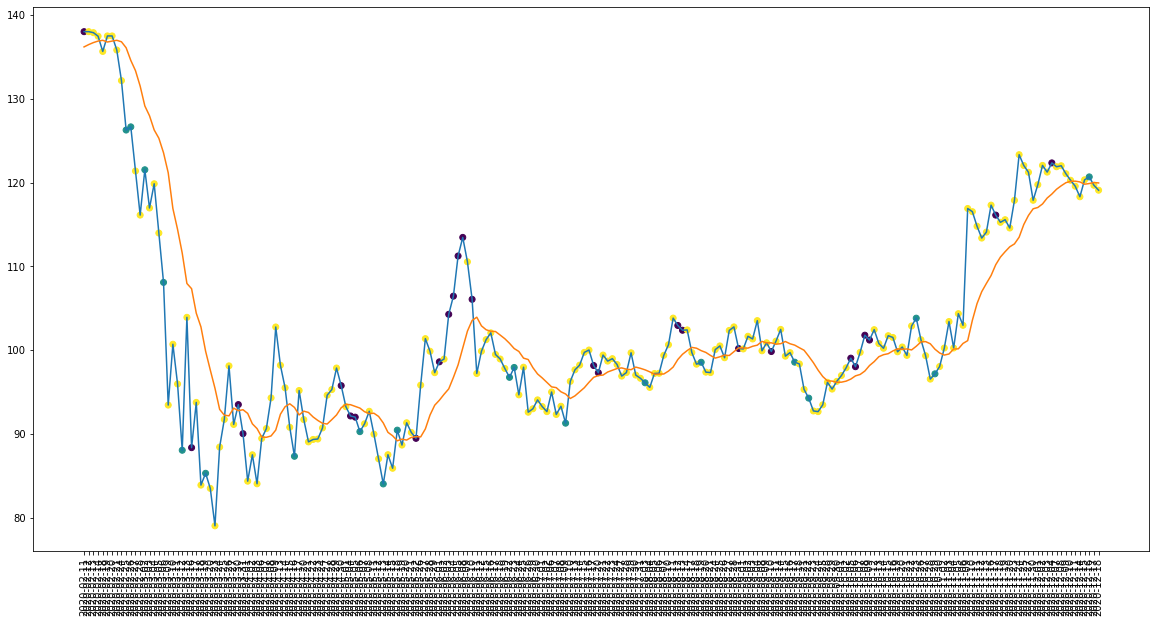

In [164]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

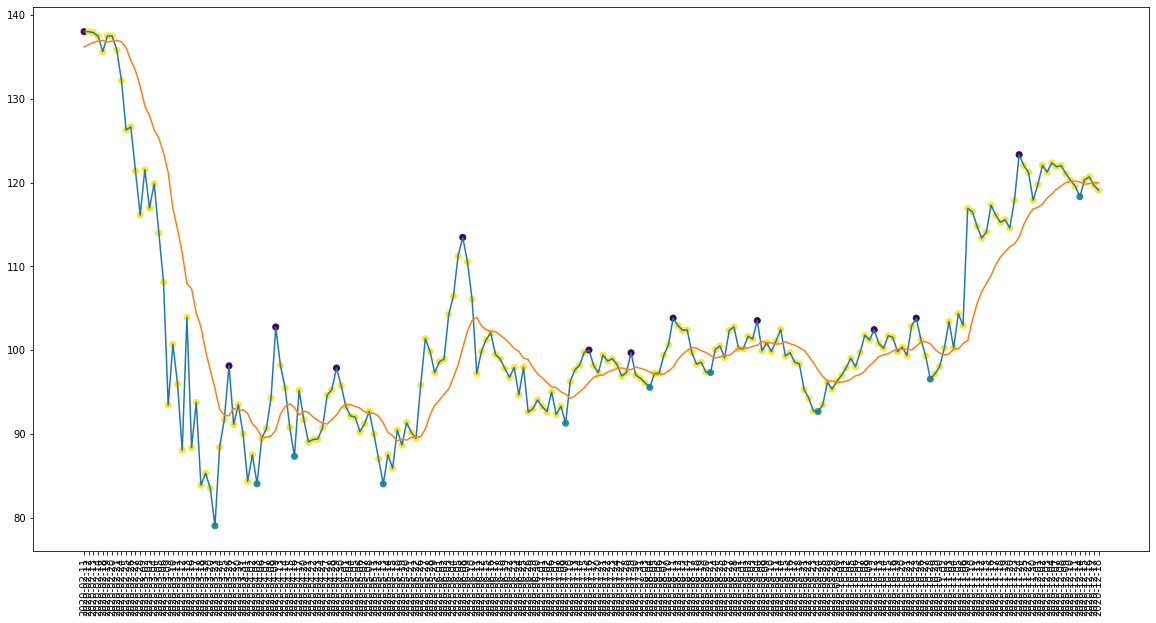

In [165]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [166]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 16
actual holds but predicted sell: 24
actual predicted holds: 157
Percentage buys correct: 30.0%
Percentage sells correct: 16.666666666666668%
Percentage holds correct: 79.69543147208122%
actual buys: 10
actual sells: 12
actual holds: 197


In [167]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[132.16000366210938, 135.63999938964844, 135.80999755859378, 137.46000671386722, 137.49000549316406, 137.49000549316406, 137.8800048828125, 138.0, 138.0]
[116.11000061035156, 116.95999908447266, 121.37000274658205, 121.5199966430664, 126.26000213623048, 126.63999938964844, 132.16000366210938, 135.80999755859378, 137.49000549316406]
Percentage buys correct: 60.0%
Percentage sells correct: 50.0%
Percentage holds correct: 83.13953488372093%


In [168]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $126.26000213623048
Shares owned at the moment: 78
Cash capital at the moment: $124.6370629157991


Stop Loss Activated!

Share price: $121.37000274658205
Shares owned at the moment: 0
Cash capital at the moment: $9565.463411560057


Share price: $121.5199966430664
Shares owned at the moment: 78
Cash capital at the moment: $60.837634120938674


Stop Loss Activated!

Share price: $116.95999908447266
Shares owned at the moment: 0
Cash capital at the moment: $9158.629642906186


Share price: $108.08000183105469
Shares owned at the moment: 84
Cash capital at the moment: $54.943008674617886


Stop Loss Activated!

Share price: $93.44000244140624
Shares owned at the moment: 0
Cash capital at the moment: $7882.318573188777


Share price: $88.05000305175781
Shares owned at the moment: 89
Cash capital at the moment: $24.31806333541408


Stop Loss Activated!

Share price: $83.88999938964844
Shares owned at the moment: 0
Cash capital at the moment: $7469.995931663509


Share price: $

In [169]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8586.858291473387
profit gained: -14.13141708526613%


## American Axle & Manufacturing Holdings, Inc

In [170]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14     OBV_7  labels
0  2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
1  2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2  2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
3  2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
4  2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


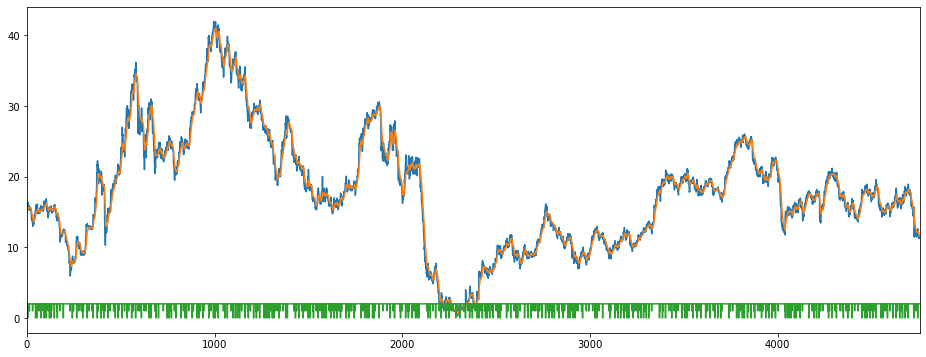

In [171]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [172]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0

In [173]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_10_price = []
data_10_willr = []
data_10_ema = []
data_10_obv = []
count = 0

for i in df.values:
    if count == 9:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_price_arr = min_max_scaler.fit_transform(data_10_price)
        data_10_ema_arr = min_max_scaler.fit_transform(data_10_ema)
        data_10_willr_arr = min_max_scaler.fit_transform(data_10_willr)
        data_10_obv_arr = min_max_scaler.fit_transform(data_10_obv)
        price_data.append(data_10_price_arr)
        willr_data.append(data_10_willr_arr)
        ema_data.append(data_10_ema_arr)
        obv_data.append(data_10_obv_arr)
        labels.append(i[-1])
        data_10_price = data_10_price[1:]
        data_10_willr = data_10_willr[1:]
        data_10_obv = data_10_obv[1:]
        data_10_ema = data_10_ema[1:]
    
    else:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [174]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [175]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64,1)
y = np.array(y)

X.shape

(4750, 64, 64, 1)

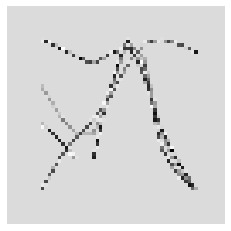

In [176]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [177]:
X = X/255

In [178]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [179]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [180]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [181]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [182]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 1 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.2796934865900385, 1: 7.2796934865900385, 2: 0.36693704132869837}
Epoch 1/200
30/30 [==============================] - 2s 62ms/step - loss: 0.2343 - accuracy: 0.3079 - mse: 1.6582 - weighted_accuracy: 0.3531 - weighted_mse: 1.6266 - val_loss: 0.2173 - val_accuracy: 0.0505 - val_mse: 1.1745 - val_weighted_accuracy: 0.0505 - val_weighted_mse: 1.1745
Epoch 2/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2070 - accuracy: 0.3147 - mse: 1.1644 - weighted_accuracy: 0.3229 - weighted_mse: 1.1674 - val_loss: 0.2040 - val_accuracy: 0.0463 - val_mse: 1.0478 - val_weighted_accuracy: 0.0463 - val_weighted_mse: 1.0478
Epoch 3/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2032 - accuracy: 0.3866 - mse: 1.1777 - weighted_accuracy: 0.3365 - weighted_mse: 1.1834 - val_loss: 0.2019 - val_accuracy: 0.0537 - val_mse: 0.8942 - val_weighted_accuracy: 0.0537 - val_weighted_mse: 0.8942
Epoch 4/200
30/30 [==============================] - 0s 10ms/step - loss: 0.201

30/30 [==============================] - 0s 10ms/step - loss: 0.1859 - accuracy: 0.1774 - mse: 1.2964 - weighted_accuracy: 0.4762 - weighted_mse: 1.2438 - val_loss: 0.2037 - val_accuracy: 0.1021 - val_mse: 1.0473 - val_weighted_accuracy: 0.1021 - val_weighted_mse: 1.0473
Epoch 29/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1815 - accuracy: 0.1689 - mse: 1.2959 - weighted_accuracy: 0.5077 - weighted_mse: 1.2546 - val_loss: 0.2051 - val_accuracy: 0.0737 - val_mse: 1.1489 - val_weighted_accuracy: 0.0737 - val_weighted_mse: 1.1489
Epoch 30/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1811 - accuracy: 0.1829 - mse: 1.3198 - weighted_accuracy: 0.5383 - weighted_mse: 1.2915 - val_loss: 0.1954 - val_accuracy: 0.1516 - val_mse: 1.0458 - val_weighted_accuracy: 0.1516 - val_weighted_mse: 1.0458
Epoch 31/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1786 - accuracy: 0.2061 - mse: 1.3229 - weighted_accuracy: 0.5449 - weighted_mse: 

Epoch 57/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1596 - accuracy: 0.1763 - mse: 1.4935 - weighted_accuracy: 0.6104 - weighted_mse: 1.4756 - val_loss: 0.2019 - val_accuracy: 0.1074 - val_mse: 1.2298 - val_weighted_accuracy: 0.1074 - val_weighted_mse: 1.2298
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1623 - accuracy: 0.1697 - mse: 1.4526 - weighted_accuracy: 0.5989 - weighted_mse: 1.4265 - val_loss: 0.2064 - val_accuracy: 0.0958 - val_mse: 1.2191 - val_weighted_accuracy: 0.0958 - val_weighted_mse: 1.2191
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1639 - accuracy: 0.1703 - mse: 1.4808 - weighted_accuracy: 0.5737 - weighted_mse: 1.4283 - val_loss: 0.2065 - val_accuracy: 0.1221 - val_mse: 1.1648 - val_weighted_accuracy: 0.1221 - val_weighted_mse: 1.1648
Epoch 60/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1596 - accuracy: 0.1742 - mse: 1.4805 - weighted_accuracy: 0.6060 - wei

Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1457 - accuracy: 0.2250 - mse: 1.6253 - weighted_accuracy: 0.6465 - weighted_mse: 1.6539 - val_loss: 0.2020 - val_accuracy: 0.1716 - val_mse: 1.5346 - val_weighted_accuracy: 0.1716 - val_weighted_mse: 1.5346
Epoch 87/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1471 - accuracy: 0.2279 - mse: 1.6947 - weighted_accuracy: 0.6457 - weighted_mse: 1.6893 - val_loss: 0.1966 - val_accuracy: 0.1979 - val_mse: 1.5493 - val_weighted_accuracy: 0.1979 - val_weighted_mse: 1.5493
Epoch 88/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1436 - accuracy: 0.2276 - mse: 1.6789 - weighted_accuracy: 0.6529 - weighted_mse: 1.7207 - val_loss: 0.2019 - val_accuracy: 0.1821 - val_mse: 1.5011 - val_weighted_accuracy: 0.1821 - val_weighted_mse: 1.5011
Epoch 89/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1427 - accuracy: 0.2368 - mse: 1.6628 - weighted_accuracy: 0.6763 - w

Epoch 115/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1317 - accuracy: 0.3574 - mse: 1.9327 - weighted_accuracy: 0.6951 - weighted_mse: 2.1497 - val_loss: 0.1812 - val_accuracy: 0.3695 - val_mse: 1.6140 - val_weighted_accuracy: 0.3695 - val_weighted_mse: 1.6140
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1244 - accuracy: 0.4008 - mse: 1.9293 - weighted_accuracy: 0.7256 - weighted_mse: 2.2067 - val_loss: 0.1818 - val_accuracy: 0.3863 - val_mse: 1.7063 - val_weighted_accuracy: 0.3863 - val_weighted_mse: 1.7063
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1242 - accuracy: 0.4011 - mse: 2.0011 - weighted_accuracy: 0.7366 - weighted_mse: 2.2962 - val_loss: 0.1802 - val_accuracy: 0.4074 - val_mse: 1.7476 - val_weighted_accuracy: 0.4074 - val_weighted_mse: 1.7476
Epoch 118/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1264 - accuracy: 0.3963 - mse: 1.9261 - weighted_accuracy: 0.7148 

Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1102 - accuracy: 0.5474 - mse: 2.3815 - weighted_accuracy: 0.7830 - weighted_mse: 3.1074 - val_loss: 0.1718 - val_accuracy: 0.5126 - val_mse: 2.1457 - val_weighted_accuracy: 0.5126 - val_weighted_mse: 2.1457
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1111 - accuracy: 0.5568 - mse: 2.3671 - weighted_accuracy: 0.7846 - weighted_mse: 3.0663 - val_loss: 0.1582 - val_accuracy: 0.6158 - val_mse: 2.1753 - val_weighted_accuracy: 0.6158 - val_weighted_mse: 2.1753
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1071 - accuracy: 0.5516 - mse: 2.4526 - weighted_accuracy: 0.8027 - weighted_mse: 3.2743 - val_loss: 0.1606 - val_accuracy: 0.6084 - val_mse: 1.9915 - val_weighted_accuracy: 0.6084 - val_weighted_mse: 1.9915
Epoch 147/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1116 - accuracy: 0.5574 - mse: 2.4723 - weighted_accuracy: 0.7776 - 

Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0958 - accuracy: 0.6463 - mse: 2.9721 - weighted_accuracy: 0.8156 - weighted_mse: 4.3741 - val_loss: 0.1535 - val_accuracy: 0.6232 - val_mse: 2.4195 - val_weighted_accuracy: 0.6232 - val_weighted_mse: 2.4195
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0975 - accuracy: 0.6629 - mse: 3.1163 - weighted_accuracy: 0.8163 - weighted_mse: 4.5202 - val_loss: 0.1357 - val_accuracy: 0.7274 - val_mse: 2.4906 - val_weighted_accuracy: 0.7274 - val_weighted_mse: 2.4906
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0944 - accuracy: 0.6624 - mse: 2.9892 - weighted_accuracy: 0.8306 - weighted_mse: 4.3032 - val_loss: 0.1277 - val_accuracy: 0.7600 - val_mse: 2.4507 - val_weighted_accuracy: 0.7600 - val_weighted_mse: 2.4507
Epoch 176/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0912 - accuracy: 0.6568 - mse: 3.0514 - weighted_accuracy: 0.8268 - 

In [183]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12118569761514664
Test accuracy: 0.7863157987594604


In [184]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.5497708  -1.7152225   0.19252256]
 [-2.1433578  -1.3004081   0.05812785]
 [-1.3476492  -1.7336512   0.0862602 ]
 ...
 [-2.4889274  -0.81068105 -0.14642839]
 [-1.7089442  -1.3422359   0.09389797]
 [-1.887477   -1.2255924  -0.01774449]]


Counter({2: 794, 1: 94, 0: 62})

In [185]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 863, 0: 43, 1: 44})

In [186]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 950
actual predicted buys: 10
actual buys but predicted sell: 1
actual buys but predicted hold: 33
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 33
actual holds but predicted buy: 83
actual holds but predicted sell: 52
actual predicted holds: 728
Percentage buys correct: 22.727272727272727%
Percentage sells correct: 20.930232558139537%
Percentage holds correct: 84.3568945538818%
actual buys: 44
actual sells: 43
actual holds: 863


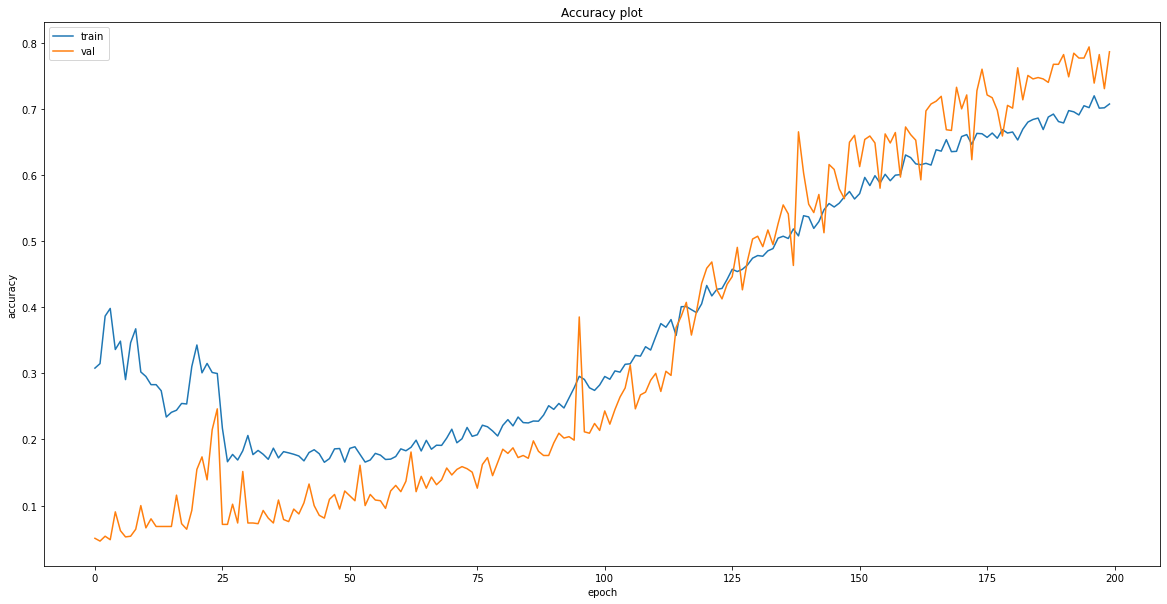

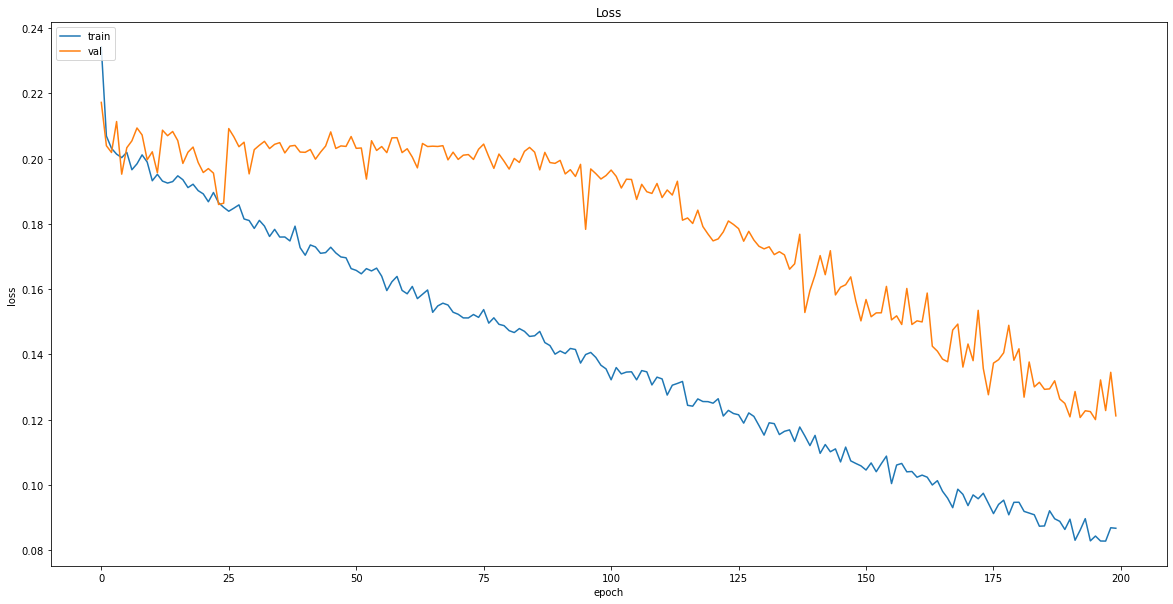

In [187]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [188]:
# Save model
model.save("models/{}".format('axl_image_cnn_buy_hold_sell_10.model'))

INFO:tensorflow:Assets written to: models/axl_image_cnn_buy_hold_sell_10.model\assets


### Test Performance

### non-recession

In [189]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-29        14.43  13.836690 -16.988400  21013100.0     2.0
2019-01-30        14.33  13.912584 -22.131150  19773800.0     2.0
2019-01-31        14.59  14.016802 -11.475401  20659500.0     2.0
2019-02-01        14.78  14.134217  -4.017864  22103800.0     2.0
2019-02-04        14.92  14.255106  -6.278041  23682100.0     0.0

In [190]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_10_price = []
data_10_willr = []
data_10_ema = []
data_10_obv = []
count = 0

for i in df.values:
    if count == 9:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_price_arr = min_max_scaler.fit_transform(data_10_price)
        data_10_ema_arr = min_max_scaler.fit_transform(data_10_ema)
        data_10_willr_arr = min_max_scaler.fit_transform(data_10_willr)
        data_10_obv_arr = min_max_scaler.fit_transform(data_10_obv)
        price_data.append(data_10_price_arr)
        willr_data.append(data_10_willr_arr)
        ema_data.append(data_10_ema_arr)
        obv_data.append(data_10_obv_arr)
        labels.append(i[-1])
        data_10_price = data_10_price[1:]
        data_10_willr = data_10_willr[1:]
        data_10_obv = data_10_obv[1:]
        data_10_ema = data_10_ema[1:]
    
    else:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [191]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [192]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64,1)
X = X/255
y = np.array(y)

In [193]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [194]:
model = tf.keras.models.load_model("models/axl_image_cnn_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1119 - accuracy: 0.8119 - mean_squared_error: 2.9279 - weighted_accuracy: 0.8119 - weighted_mean_squared_error: 2.9279
Test loss: 0.11188535392284393
Test accuracy: 0.8119266033172607


In [195]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 187, 0: 14, 1: 17})

In [196]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [197]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2019-02-11        14.01  14.312907 -83.060094  17347800.0     2.0   
2019-02-12        14.34  14.266306 -68.852439  19189100.0     2.0   
2019-02-13        14.45  14.277643 -50.819664  21493700.0     2.0   
2019-02-14        14.70  14.304160 -44.808757  23008200.0     2.0   
2019-02-15        16.83  14.365058 -31.147561  25735200.0     2.0   

            predictions  actual  
Date                             
2019-02-11            2       2  
2019-02-12            2       2  
2019-02-13            2       2  
2019-02-14            2       2  
2019-02-15            0       2

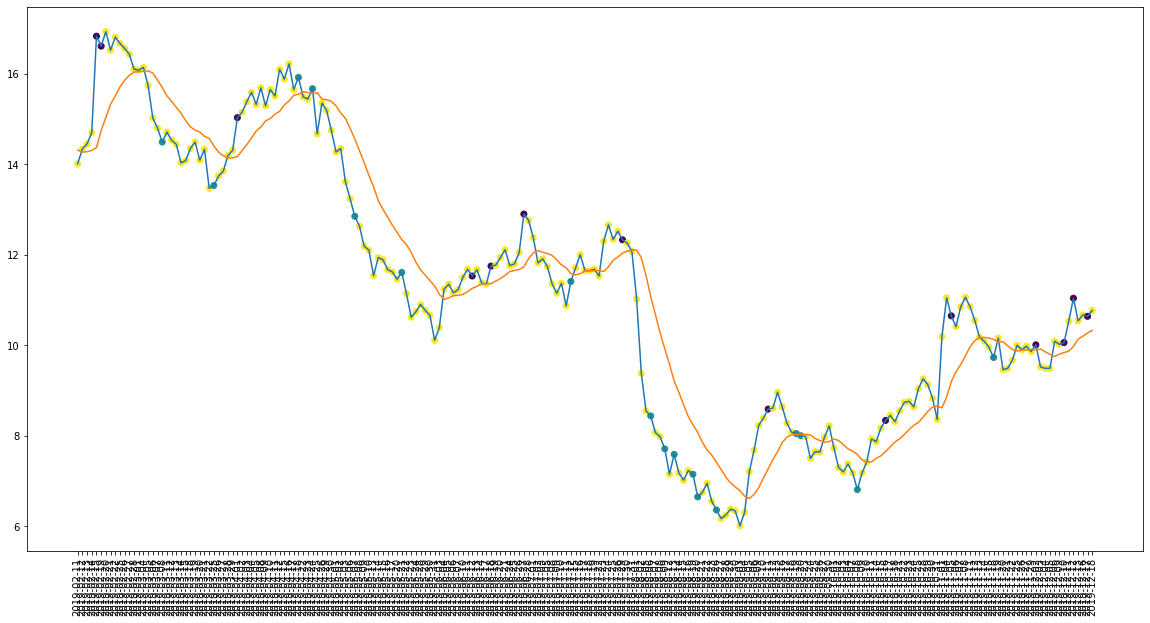

In [198]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

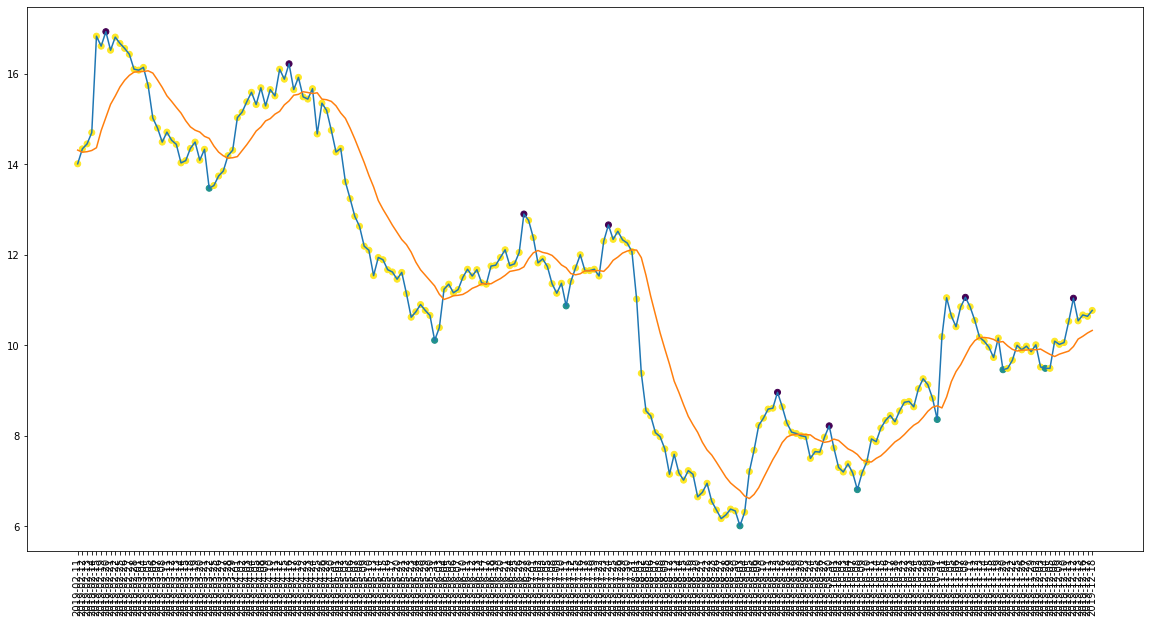

In [199]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [200]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 6
actual holds but predicted buy: 16
actual holds but predicted sell: 12
actual predicted holds: 174
Percentage buys correct: 12.5%
Percentage sells correct: 25.0%
Percentage holds correct: 86.13861386138613%
actual buys: 8
actual sells: 8
actual holds: 202


In [201]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[14.010000228881836, 14.34000015258789, 14.449999809265135, 14.699999809265135, 16.520000457763672, 16.610000610351562, 16.809999465942386, 16.829999923706055, 16.930000305175778]
[16.079999923706055, 16.100000381469727, 16.139999389648438, 16.430000305175778, 16.520000457763672, 16.559999465942386, 16.670000076293945, 16.809999465942386, 16.930000305175778]
Percentage buys correct: 35.294117647058826%
Percentage sells correct: 64.28571428571429%
Percentage holds correct: 84.94623655913979%


In [202]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $14.489999771118164
Shares owned at the moment: 688
Cash capital at the moment: $3.465077903747442


Stop Loss Activated!

Share price: $14.029999732971193
Shares owned at the moment: 0
Cash capital at the moment: $9629.560134693147


Share price: $13.529999732971193
Shares owned at the moment: 709
Cash capital at the moment: $10.410207037210057


Price increase from previously bought: 10.781824701981456%
Share price: $15.029999732971193
Shares owned at the moment: 0
Cash capital at the moment: $10637.375275734426


Share price: $15.920000076293945
Shares owned at the moment: 666
Cash capital at the moment: $5.49774478292602


Stop Loss Activated!

Share price: $15.4399995803833
Shares owned at the moment: 0
Cash capital at the moment: $10260.259106086733


Share price: $15.670000076293945
Shares owned at the moment: 652
Cash capital at the moment: $15.322746206284137


Stop Loss Activated!

Share price: $14.670000076293945
Shares owned at the moment: 0
Cash capital at the

In [203]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7647.909066392421
profit gained: -23.520909336075793%


### recession

In [204]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test2.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-29         9.56  9.554791 -45.714255  -464900.0     2.0
2020-01-30         9.44  9.537131 -47.107490 -1769800.0     2.0
2020-01-31         9.41  9.517572 -49.586807 -2999800.0     1.0
2020-02-03         9.24  9.474869 -63.636399 -4264900.0     2.0
2020-02-04         9.45  9.471043 -51.851894 -2731100.0     2.0

In [205]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_10_price = []
data_10_willr = []
data_10_ema = []
data_10_obv = []
count = 0

for i in df.values:
    if count == 9:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_price_arr = min_max_scaler.fit_transform(data_10_price)
        data_10_ema_arr = min_max_scaler.fit_transform(data_10_ema)
        data_10_willr_arr = min_max_scaler.fit_transform(data_10_willr)
        data_10_obv_arr = min_max_scaler.fit_transform(data_10_obv)
        price_data.append(data_10_price_arr)
        willr_data.append(data_10_willr_arr)
        ema_data.append(data_10_ema_arr)
        obv_data.append(data_10_obv_arr)
        labels.append(i[-1])
        data_10_price = data_10_price[1:]
        data_10_willr = data_10_willr[1:]
        data_10_obv = data_10_obv[1:]
        data_10_ema = data_10_ema[1:]
    
    else:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [206]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [207]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [208]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [209]:
model = tf.keras.models.load_model("models/axl_image_cnn_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1194 - accuracy: 0.8128 - mean_squared_error: 2.9339 - weighted_accuracy: 0.8128 - weighted_mean_squared_error: 2.9339
Test loss: 0.11939775943756104
Test accuracy: 0.8127853870391846


In [210]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 190, 1: 18, 0: 11})

In [211]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [212]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels  predictions  \
Date                                                                           
2020-02-11         9.84  9.643918 -57.638900 -3274300.0     2.0            2   
2020-02-12        10.34  9.674085 -36.805548 -1876100.0     0.0            2   
2020-02-13        10.22  9.776533 -16.568036  -291400.0     2.0            2   
2020-02-14         8.77  9.844759 -23.668622 -1567700.0     2.0            2   
2020-02-18         8.27  9.679411 -90.686248 -6644000.0     2.0            2   

            actual  
Date                
2020-02-11       2  
2020-02-12       0  
2020-02-13       2  
2020-02-14       2  
2020-02-18       2

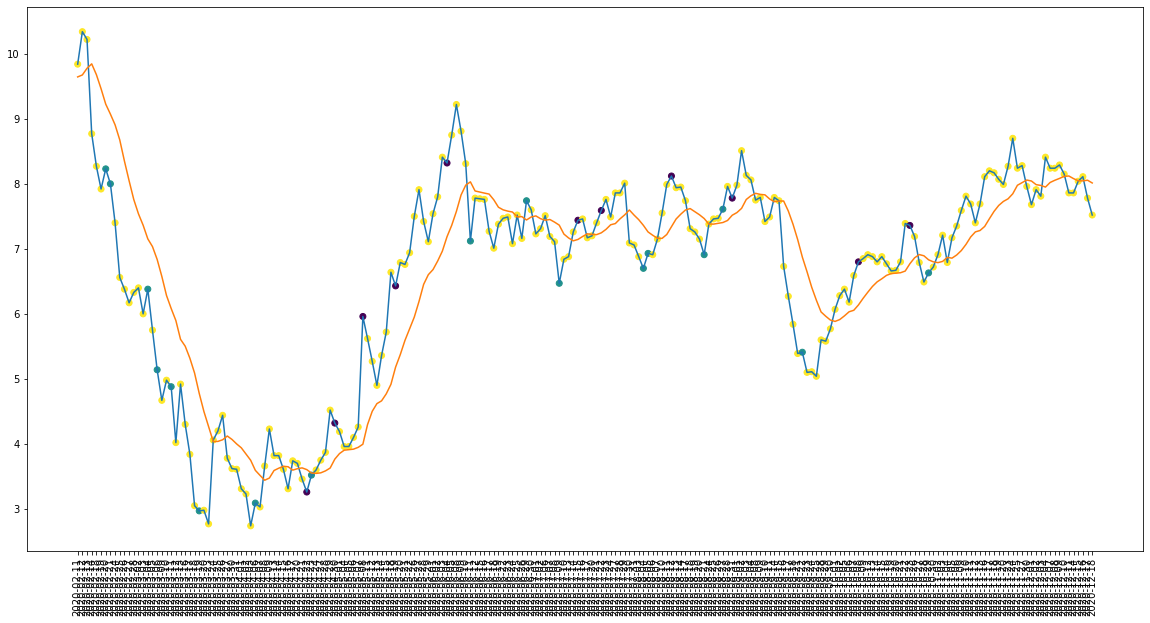

In [213]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

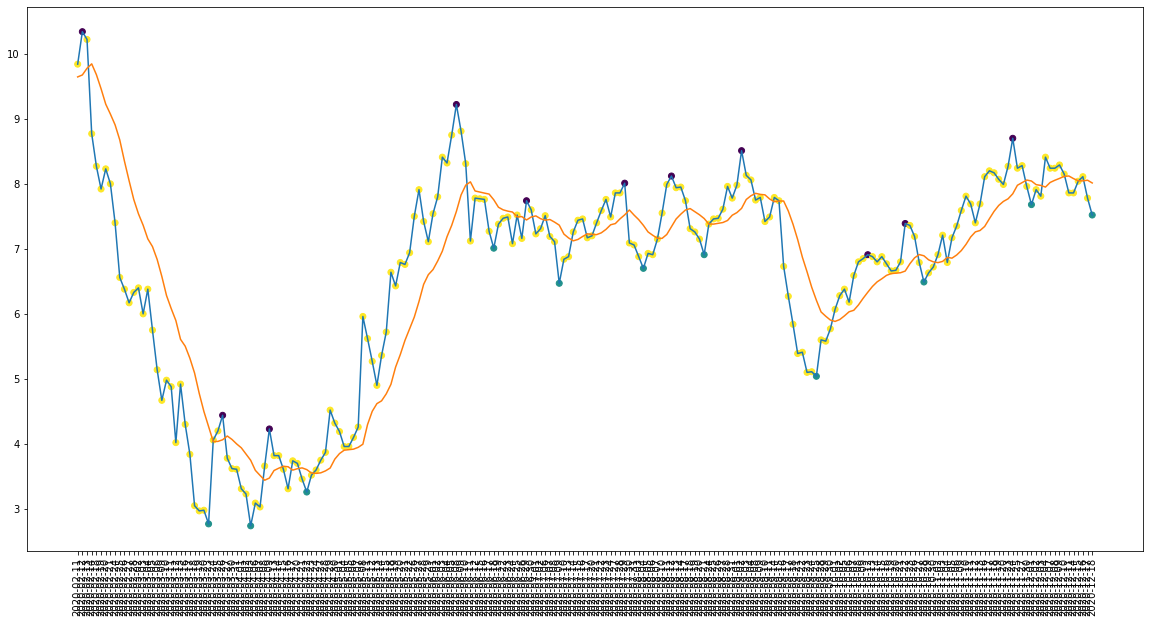

In [214]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [215]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 14
actual holds but predicted sell: 9
actual predicted holds: 174
Percentage buys correct: 27.272727272727273%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 88.3248730964467%
actual buys: 11
actual sells: 11
actual holds: 197


In [216]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[7.400000095367432, 7.920000076293945, 8.0, 8.229999542236326, 8.270000457763674, 8.770000457763674, 9.84000015258789, 10.220000267028807, 10.34000015258789]
[6.0, 6.170000076293945, 6.329999923706055, 6.380000114440918, 6.4000000953674325, 6.559999942779541, 7.400000095367432, 8.0, 8.229999542236326]
Percentage buys correct: 52.94117647058823%
Percentage sells correct: 63.63636363636363%
Percentage holds correct: 86.84210526315789%


In [217]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $8.229999542236326
Shares owned at the moment: 1211
Cash capital at the moment: $6.062598376274764


Stop Loss Activated!

Share price: $8.0
Shares owned at the moment: 0
Cash capital at the moment: $9667.420598376275


Share price: $8.0
Shares owned at the moment: 1205
Cash capital at the moment: $0.9105983762747201


Stop Loss Activated!

Share price: $7.400000095367432
Shares owned at the moment: 0
Cash capital at the moment: $8893.388962978006


Share price: $6.380000114440918
Shares owned at the moment: 1390
Cash capital at the moment: $0.8012534676799987


Stop Loss Activated!

Share price: $5.75
Shares owned at the moment: 0
Cash capital at the moment: $7971.32187846768


Share price: $5.139999866485597
Shares owned at the moment: 1546
Cash capital at the moment: $3.029375448583778


Stop Loss Activated!

Share price: $4.670000076293945
Shares owned at the moment: 0
Cash capital at the moment: $7202.994988074659


Share price: $4.880000114440918
Shares owned at the 

In [218]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7601.479205735086
profit gained: -23.98520794264914%
